<a href="https://colab.research.google.com/github/GuptaTanay/Battery-Level-Prediction/blob/main/Analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import numpy as np
import pandas
import datetime
import seaborn as sns
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
#from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, accuracy_score,classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pandas.read_excel( 'BatteryLogs_changed.xlsx' )

In [ ]:
data.head()

timestamp                             scode  level  Unnamed: 3  \
0  2021-04-23 07:44:08  3320e01c4f1d6fa898adbeda981150dc      6         NaN   
1  2021-04-23 07:04:07  ea05a2a12ce40e29289cc6dd9587b665      7         NaN   
2  2021-04-22 14:56:25  ca1441c0b8503ef6e77620bf602dae49      4         NaN   
3  2021-04-22 14:47:49  ca1441c0b8503ef6e77620bf602dae49      4         NaN   
4  2021-04-22 13:51:47  c47b970da888de5b0c0f299ed8a0cda7      2         NaN   

   Unnamed: 4  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [ ]:
data = data.rename(columns={'timestamp':'ended','scode':'session','level':'battarie_energie'})
allowed_columns = ['session', 'ended', 'battarie_energie']
complete_data = data[allowed_columns]

In [ ]:
complete_data.head()

session                ended  battarie_energie
0  3320e01c4f1d6fa898adbeda981150dc  2021-04-23 07:44:08                 6
1  ea05a2a12ce40e29289cc6dd9587b665  2021-04-23 07:04:07                 7
2  ca1441c0b8503ef6e77620bf602dae49  2021-04-22 14:56:25                 4
3  ca1441c0b8503ef6e77620bf602dae49  2021-04-22 14:47:49                 4
4  c47b970da888de5b0c0f299ed8a0cda7  2021-04-22 13:51:47                 2

In [ ]:
all_sessions = complete_data['session'].unique()
session_to_id_map = {}
for i in range(len(all_sessions)):
    session_to_id_map[all_sessions[i]] = 'id_' + str(i+1)

complete_data['session'] = complete_data['session'].transform( lambda x : session_to_id_map[x] )
complete_data

session                ended  battarie_energie
0      id_1  2021-04-23 07:44:08                 6
1      id_2  2021-04-23 07:04:07                 7
2      id_3  2021-04-22 14:56:25                 4
3      id_3  2021-04-22 14:47:49                 4
4      id_4  2021-04-22 13:51:47                 2
..      ...                  ...               ...
580    id_8  2020-07-30 07:27:30                 5
581   id_10  2020-07-29 20:09:07                 1
582   id_10  2020-07-29 19:57:52                 2
583   id_10  2020-07-29 19:46:33                 3
584    id_7  2020-07-29 13:59:49                 6

[585 rows x 3 columns]

#### Let's look at the data description 

In [ ]:
complete_data.describe()

battarie_energie
count         585.00000
mean            4.40000
std             1.68006
min             0.00000
25%             3.00000
50%             5.00000
75%             6.00000
max             7.00000

In [ ]:
print('Unique value of battery levels : ', complete_data['battarie_energie'].dropna().unique())

Unique value of battery levels :  [6 7 4 2 5 1 3 0]


In [ ]:
complete_data.isna().sum()

session             0
ended               0
battarie_energie    0
dtype: int64

#### We see that we do not have any missing data points, so we skip the imputing

#### We see that minimum value for battery levels is 0 and maximum value for battery levels is 7. But now let's look at the minimum and maximum battery levels for each person separately.

In [ ]:
complete_data.groupby(['session']).describe().head()

battarie_energie                                             
                   count      mean       std  min  25%  50%  75%  max
session                                                              
id_1                21.0  4.571429  1.247855  1.0  4.0  5.0  5.0  7.0
id_10               39.0  2.615385  0.906566  1.0  2.0  3.0  3.0  4.0
id_11               14.0  5.642857  0.633324  5.0  5.0  6.0  6.0  7.0
id_12               33.0  3.757576  1.346994  1.0  3.0  4.0  5.0  7.0
id_13               23.0  3.478261  1.274561  1.0  3.0  3.0  4.5  6.0

### We see that few ids have 0 as battery levels as well, let's look closely at them

In [ ]:
complete_data[['session','battarie_energie']].groupby(['battarie_energie']).describe()

session                   
                   count unique    top freq
battarie_energie                           
0                      4      3   id_4    2
1                     22     10  id_10    6
2                     75     11   id_4   39
3                     78     12  id_10   20
4                     95     15  id_16   14
5                    124     18  id_16   21
6                    141     16  id_16   44
7                     46     13   id_2   14

#### Given we only have 4 of those rows, we will remove these rows

In [ ]:
complete_data = complete_data[ complete_data['battarie_energie'] > 0 ]

In [ ]:
complete_data[['session','battarie_energie']].groupby(['battarie_energie']).describe()

session                   
                   count unique    top freq
battarie_energie                           
1                     22     10  id_10    6
2                     75     11   id_4   39
3                     78     12  id_10   20
4                     95     15  id_16   14
5                    124     18  id_16   21
6                    141     16  id_16   44
7                     46     13   id_2   14

In [ ]:
# to confirm
assert(complete_data['battarie_energie'].isna().sum() == 0)

#### Now for 'ended' column! Let's look at that. We will sort it by time, so that later during analysis we can consider order of rows as order of time

In [ ]:
final_data = pandas.DataFrame()

unique_people = complete_data['session'].unique()
for session in unique_people:
    data_for_session = complete_data[ complete_data['session'] == session ]
    data_for_session['ended'] = pandas.to_datetime(data_for_session['ended'])
    data_for_session = data_for_session.sort_values(by='ended')
    final_data = final_data.append(data_for_session)
    
final_data.groupby(['session']).describe()

battarie_energie                                               
                   count      mean       std  min   25%  50%   75%  max
session                                                                
id_1                21.0  4.571429  1.247855  1.0  4.00  5.0  5.00  7.0
id_10               39.0  2.615385  0.906566  1.0  2.00  3.0  3.00  4.0
id_11               14.0  5.642857  0.633324  5.0  5.00  6.0  6.00  7.0
id_12               33.0  3.757576  1.346994  1.0  3.00  4.0  5.00  7.0
id_13               23.0  3.478261  1.274561  1.0  3.00  3.0  4.50  6.0
id_14                2.0  5.500000  0.707107  5.0  5.25  5.5  5.75  6.0
id_15               27.0  2.888889  1.281025  1.0  2.00  3.0  3.50  7.0
id_16               89.0  5.561798  0.891310  4.0  5.00  6.0  6.00  7.0
id_17               12.0  3.666667  1.370689  1.0  2.75  4.0  5.00  5.0
id_18                5.0  4.600000  2.880972  1.0  2.00  6.0  7.00  7.0
id_19               14.0  5.642857  1.150728  3.0  5.00  5.5  6.75  7.0
id_2                27.0  6.259259  0.944319  4.0  6.00  7.0  7.00  7.0
id_20                2.0  6.000000  1.414214  5.0  5.50  6.0  6.50  7.0
id_21                2.0  3.500000  3.535534  1.0  2.25  3.5  4.75  6.0
id_22                2.0  5.000000  1.414214  4.0  4.50  5.0  5.50  6.0
id_23                1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
id_24                2.0  5.000000  0.000000  5.0  5.00  5.0  5.00  5.0
id_3                23.0  4.478261  1.122884  3.0  4.00  4.0  5.00  7.0
id_4                49.0  2.163265  0.986301  1.0  2.00  2.0  2.00  6.0
id_5                40.0  4.825000  1.009887  2.0  4.00  5.0  6.00  6.0
id_6                76.0  4.828947  1.454997  2.0  4.00  5.0  6.00  7.0
id_7                26.0  5.884615  0.765607  4.0  5.25  6.0  6.00  7.0
id_8                46.0  4.543478  1.241979  1.0  4.00  5.0  5.00  7.0
id_9                 6.0  3.666667  0.516398  3.0  3.25  4.0  4.00  4.0

#### Now we see there are some sessions with single data entry, let's remove all of them as those won't be useful for model predictions

In [ ]:
data = pandas.DataFrame()

unique_people = final_data['session'].unique()
for session in unique_people:
    data_for_session = final_data[ final_data['session'] == session ]
    if len(data_for_session) == 1:
        continue
    data = data.append(data_for_session)

data.groupby(['session']).describe()

battarie_energie                                               
                   count      mean       std  min   25%  50%   75%  max
session                                                                
id_1                21.0  4.571429  1.247855  1.0  4.00  5.0  5.00  7.0
id_10               39.0  2.615385  0.906566  1.0  2.00  3.0  3.00  4.0
id_11               14.0  5.642857  0.633324  5.0  5.00  6.0  6.00  7.0
id_12               33.0  3.757576  1.346994  1.0  3.00  4.0  5.00  7.0
id_13               23.0  3.478261  1.274561  1.0  3.00  3.0  4.50  6.0
id_14                2.0  5.500000  0.707107  5.0  5.25  5.5  5.75  6.0
id_15               27.0  2.888889  1.281025  1.0  2.00  3.0  3.50  7.0
id_16               89.0  5.561798  0.891310  4.0  5.00  6.0  6.00  7.0
id_17               12.0  3.666667  1.370689  1.0  2.75  4.0  5.00  5.0
id_18                5.0  4.600000  2.880972  1.0  2.00  6.0  7.00  7.0
id_19               14.0  5.642857  1.150728  3.0  5.00  5.5  6.75  7.0
id_2                27.0  6.259259  0.944319  4.0  6.00  7.0  7.00  7.0
id_20                2.0  6.000000  1.414214  5.0  5.50  6.0  6.50  7.0
id_21                2.0  3.500000  3.535534  1.0  2.25  3.5  4.75  6.0
id_22                2.0  5.000000  1.414214  4.0  4.50  5.0  5.50  6.0
id_24                2.0  5.000000  0.000000  5.0  5.00  5.0  5.00  5.0
id_3                23.0  4.478261  1.122884  3.0  4.00  4.0  5.00  7.0
id_4                49.0  2.163265  0.986301  1.0  2.00  2.0  2.00  6.0
id_5                40.0  4.825000  1.009887  2.0  4.00  5.0  6.00  6.0
id_6                76.0  4.828947  1.454997  2.0  4.00  5.0  6.00  7.0
id_7                26.0  5.884615  0.765607  4.0  5.25  6.0  6.00  7.0
id_8                46.0  4.543478  1.241979  1.0  4.00  5.0  5.00  7.0
id_9                 6.0  3.666667  0.516398  3.0  3.25  4.0  4.00  4.0

In [ ]:
data.isna().sum()

session             0
ended               0
battarie_energie    0
dtype: int64

#### There are no outliers in final_data as we see in description! So we are good to go

### Data looks good! We will now proceed with the analysis. One thing to note before we proceed with the analysis, we have different minimum and maximum battery levels for different people, so our algorithms would be limited to those data points. 

In [ ]:
accuracies_global = {}
classification_reports_all = {}

In [ ]:
def plot_curves(timestamps, actual_values, predicted_values):
    for session in actual_values.keys():
        
        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        fig.suptitle('For session : ' + str(session))
        
        ts = timestamps[session]
        av = actual_values[session]
        pv = predicted_values[session]
        ax.plot(ts, av, label='Actual')
        ax.plot(ts, pv, label='Predicted')
        ax.set_ylim([0.5,7.5])
        ax.legend()
        
        plt.show()

### 1. ARIMAX

In [ ]:
def calculate_arimax():
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]
        actual_series = list( input_data['battarie_energie'].astype(int) )
        sarimax = sm.tsa.statespace.SARIMAX(actual_series, seasonal_order=(0,0,0,0), enforce_stationarity=False).fit()
        predicted_series = [ int(np.around(x)) for x in sarimax.predict() ]

        testScore = accuracy_score(actual_series, predicted_series)
        print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data['ended'])
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_arimax()

For id:  id_1  accuracy is :  0.47619047619047616
For id:  id_2  accuracy is :  0.37037037037037035
For id:  id_3  accuracy is :  0.2608695652173913
For id:  id_4  accuracy is :  0.7346938775510204
For id:  id_5  accuracy is :  0.475
For id:  id_6  accuracy is :  0.21052631578947367
For id:  id_7  accuracy is :  0.38461538461538464
For id:  id_8  accuracy is :  0.32608695652173914
For id:  id_9  accuracy is :  0.3333333333333333
For id:  id_10  accuracy is :  0.41025641025641024
For id:  id_11  accuracy is :  0.42857142857142855
For id:  id_12  accuracy is :  0.36363636363636365
For id:  id_13  accuracy is :  0.2608695652173913
For id:  id_14  accuracy is :  0.5
For id:  id_15  accuracy is :  0.2962962962962963
For id:  id_16  accuracy is :  0.6179775280898876
For id:  id_17  accuracy is :  0.08333333333333333
For id:  id_18  accuracy is :  0.2
For id:  id_19  accuracy is :  0.14285714285714285
For id:  id_20  accuracy is :  0.5
For id:  id_21  accuracy is :  0.5
For id:  id_22  accura

Average accuracy via ARIMAX is :  0.38589062381945405
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        23
           1       0.18      0.20      0.19        20
           2       0.58      0.54      0.56        79
           3       0.41      0.43      0.42        75
           4       0.32      0.33      0.32        91
           5       0.44      0.37      0.40       148
           6       0.40      0.52      0.45       107
           7       0.35      0.44      0.39        36
           8       1.00      0.00      0.00         1

    accuracy                           0.41       580
   macro avg       0.52      0.32      0.30       580
weighted avg       0.44      0.41      0.40       580



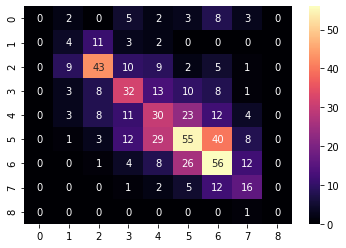

In [ ]:
print('Average accuracy via ARIMAX is : ', sum(accuracies)/len(accuracies))

true_all = np.hstack(list(actual_values.values()))
preds_all = np.hstack(list(predicted_values.values()))
classification_reports_all['ARIMAX'] = classification_report(preds_all , true_all, zero_division=True)

unique_pred = list(set(preds_all))
unique_pred.sort()
cmatrix = pandas.DataFrame(confusion_matrix(preds_all , true_all), columns=unique_pred)
cmatrix.index = unique_pred
_ = sns.heatmap(cmatrix, cmap="magma" , annot = True)
print(classification_reports_all['ARIMAX'])
accuracies_global['ARIMAX'] = accuracies

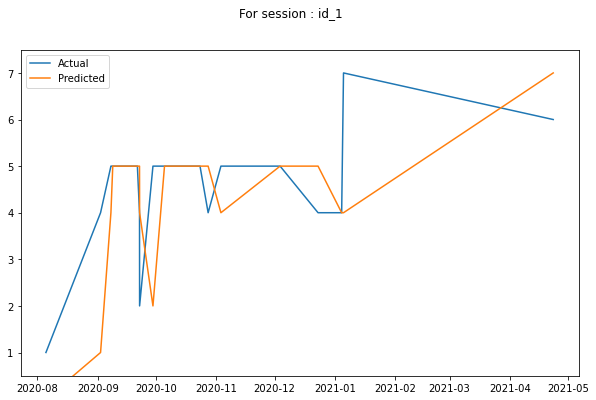

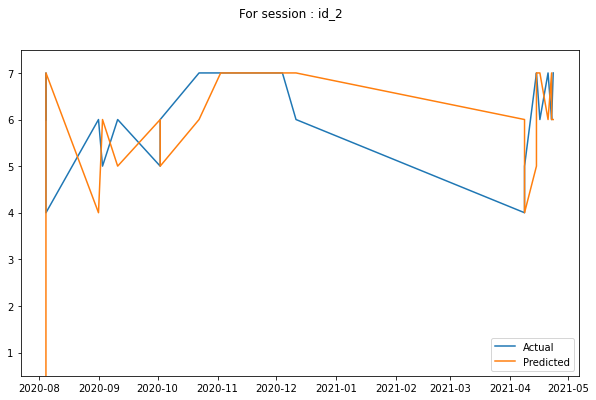

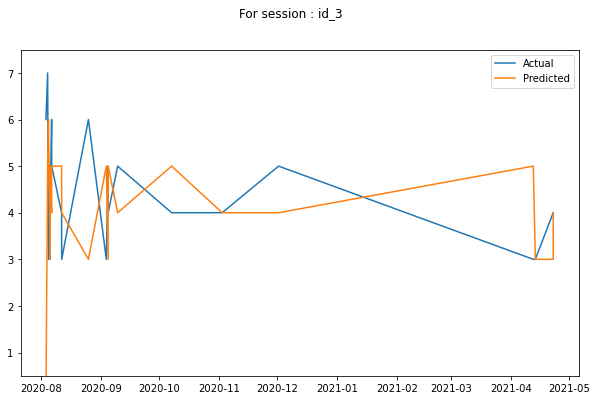

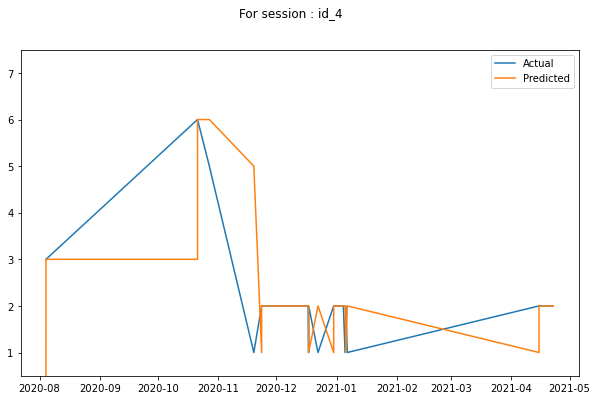

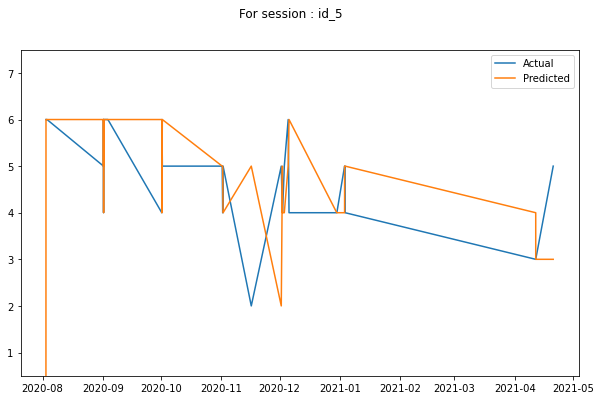

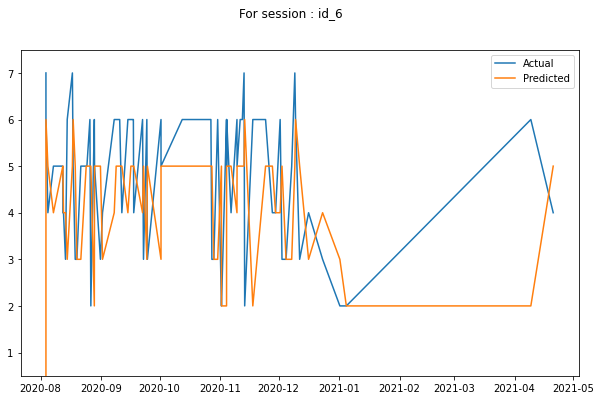

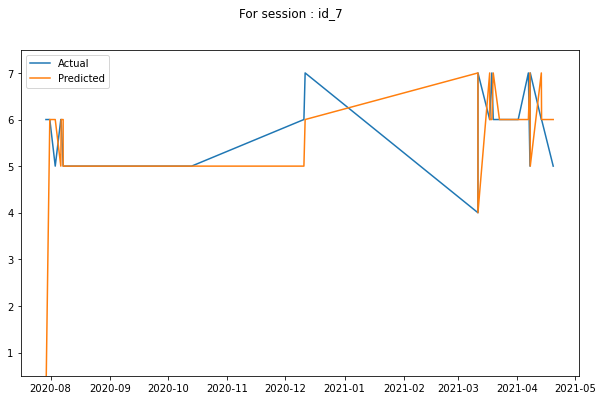

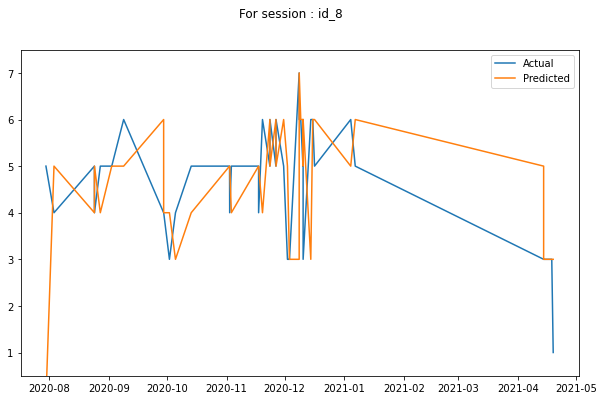

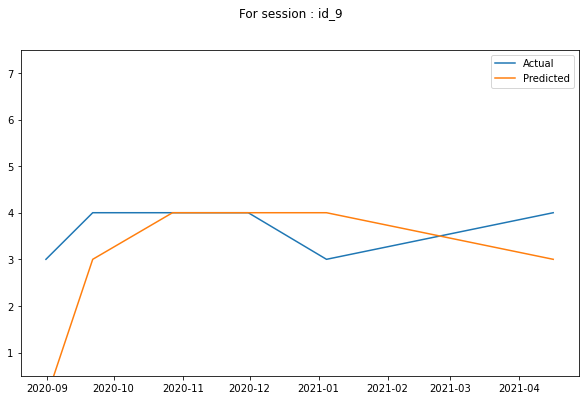

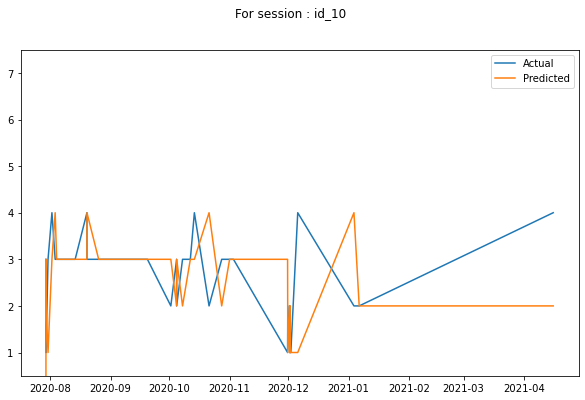

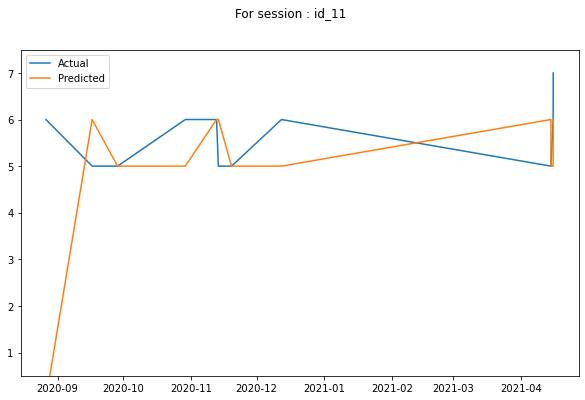

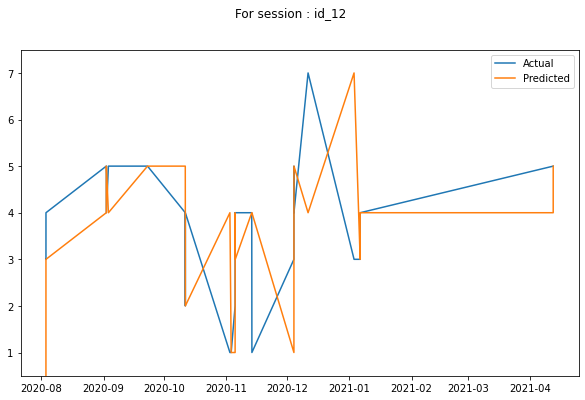

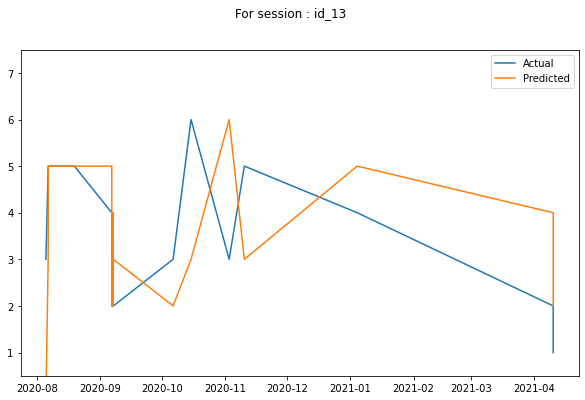

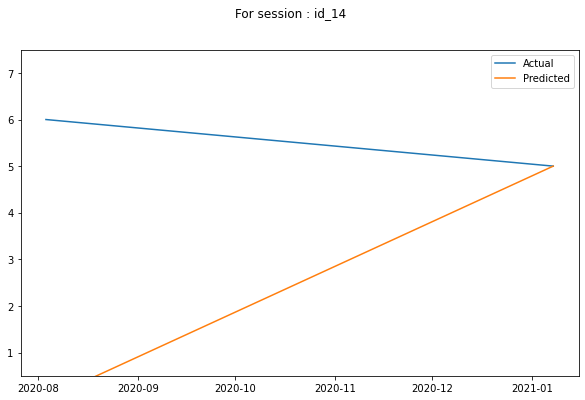

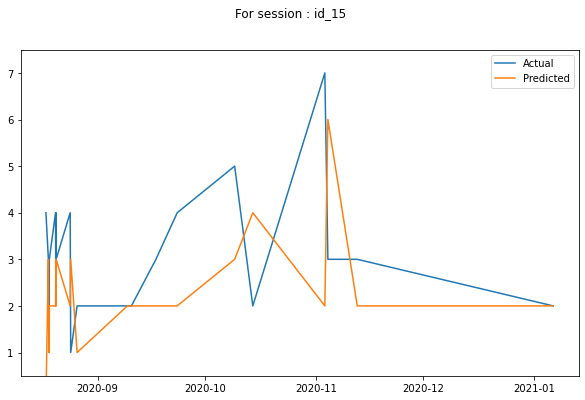

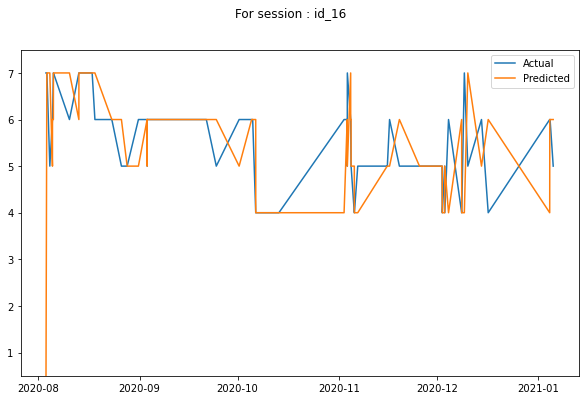

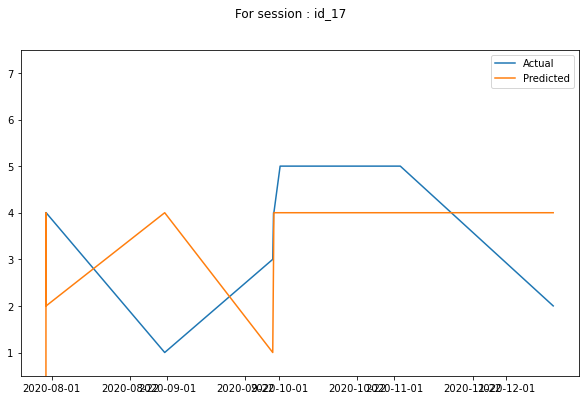

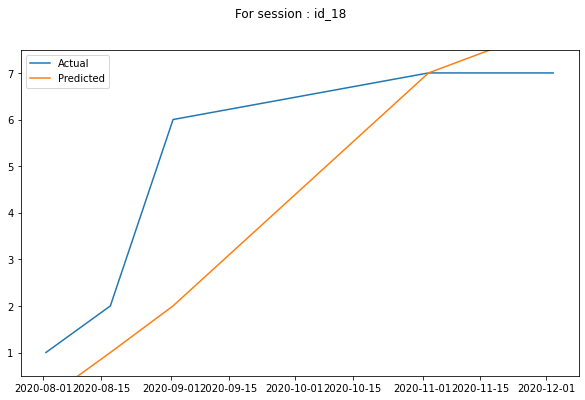

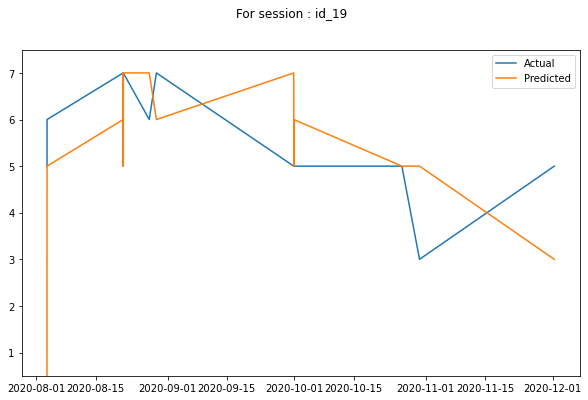

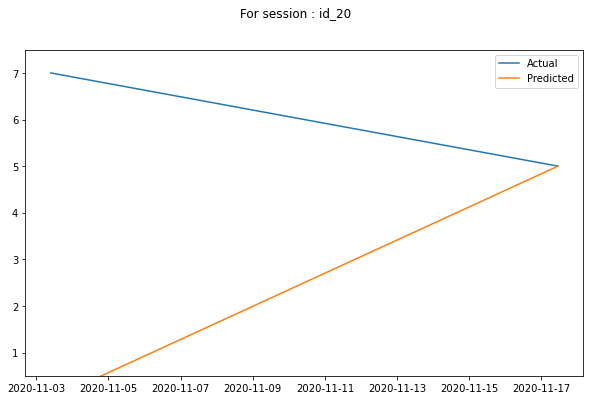

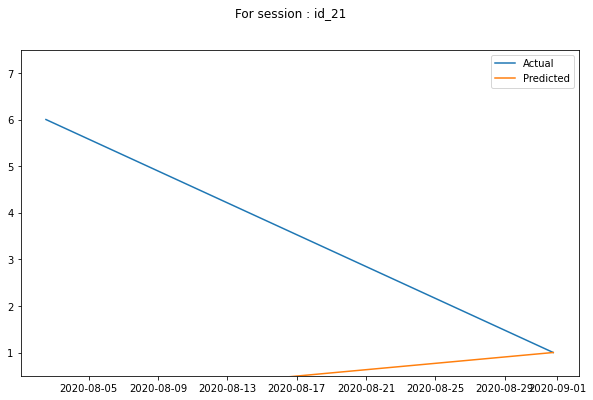

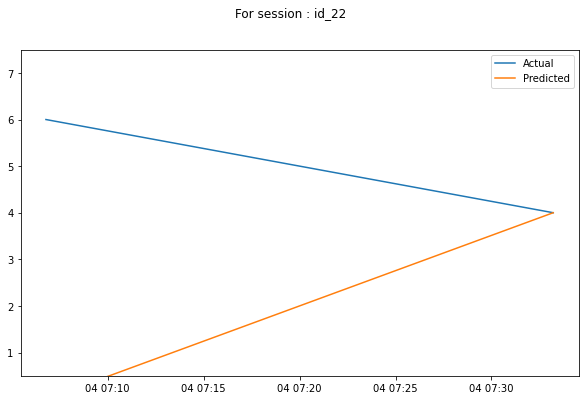

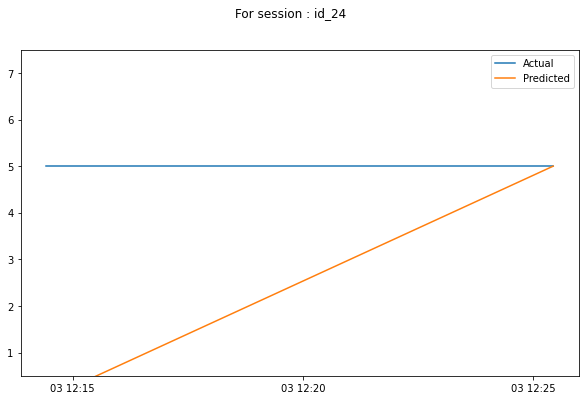

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

### 2. SARIMAX

In [ ]:
def calculate_sarimax(seasonality, log=True):
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]
        actual_series = list( input_data['battarie_energie'].astype(int) )
        
        sarimax = sm.tsa.statespace.SARIMAX(actual_series, seasonal_order=(1,0,0,seasonality), enforce_stationarity=False).fit()
        predicted_series = [ int(np.around(x)) for x in sarimax.predict() ]
            
        testScore = accuracy_score(actual_series, predicted_series)
        if log:
            print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data['ended'])
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
max_accuracy = -1
seasonality_max = -1
for seasonality in [2,3,4,5,6]:
    accuracies, timestamps, actual_values, predicted_values = calculate_sarimax(2, log=False)
    avg_acc = sum(accuracies)/len(accuracies)
    if max_accuracy < avg_acc:
        max_accuracy = avg_acc
        seasonality_max = seasonality
print('Maximum average accuracy of {} with seasonality as {}'.format(max_accuracy, seasonality_max))

Maximum average accuracy of 0.40564665090316615 with seasonality as 2


In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_sarimax(2)

For id:  id_1  accuracy is :  0.3333333333333333
For id:  id_2  accuracy is :  0.37037037037037035
For id:  id_3  accuracy is :  0.13043478260869565
For id:  id_4  accuracy is :  0.7346938775510204
For id:  id_5  accuracy is :  0.475
For id:  id_6  accuracy is :  0.3026315789473684
For id:  id_7  accuracy is :  0.3076923076923077
For id:  id_8  accuracy is :  0.30434782608695654
For id:  id_9  accuracy is :  0.3333333333333333
For id:  id_10  accuracy is :  0.46153846153846156
For id:  id_11  accuracy is :  0.5
For id:  id_12  accuracy is :  0.36363636363636365
For id:  id_13  accuracy is :  0.391304347826087
For id:  id_14  accuracy is :  0.5
For id:  id_15  accuracy is :  0.14814814814814814
For id:  id_16  accuracy is :  0.6067415730337079
For id:  id_17  accuracy is :  0.16666666666666666
For id:  id_18  accuracy is :  0.4
For id:  id_19  accuracy is :  0.5
For id:  id_20  accuracy is :  0.5
For id:  id_21  accuracy is :  0.5
For id:  id_22  accuracy is :  0.5
For id:  id_24  accur

Average accuracy via SARIMAX is :  0.40564665090316615
              precision    recall  f1-score   support

          -1       1.00      0.00      0.00         2
           0       1.00      0.00      0.00        27
           1       0.23      0.23      0.23        22
           2       0.57      0.55      0.56        76
           3       0.40      0.41      0.40        76
           4       0.33      0.33      0.33        95
           5       0.39      0.42      0.40       115
           6       0.47      0.50      0.48       132
           7       0.41      0.56      0.47        34
           8       1.00      0.00      0.00         1

    accuracy                           0.42       580
   macro avg       0.58      0.30      0.29       580
weighted avg       0.45      0.42      0.41       580



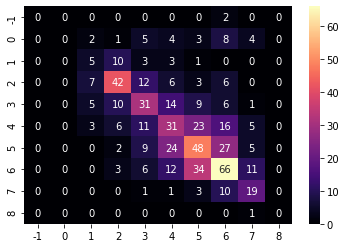

In [ ]:
print('Average accuracy via SARIMAX is : ', sum(accuracies)/len(accuracies))

true_all = np.hstack(list(actual_values.values()))
preds_all = np.hstack(list(predicted_values.values()))
unique_pred = list(set(preds_all))
unique_pred.sort()
classification_reports_all['SARIMAX(2)'] = classification_report(preds_all , true_all, zero_division=True)
cmatrix = pandas.DataFrame(confusion_matrix(preds_all , true_all), columns=unique_pred)
cmatrix.index = unique_pred
_ = sns.heatmap(cmatrix, cmap="magma" , annot = True)
print(classification_reports_all['SARIMAX(2)'])
accuracies_global['SARIMAX(2)'] = accuracies

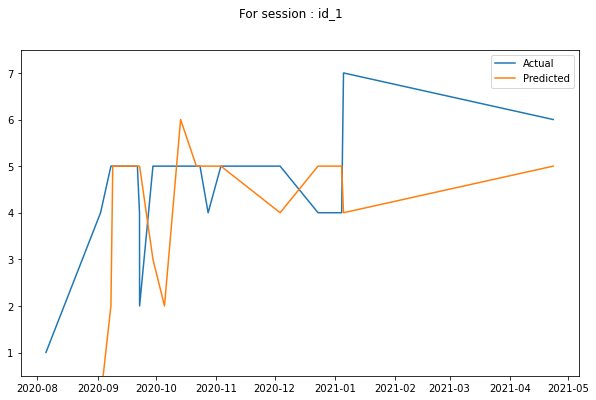

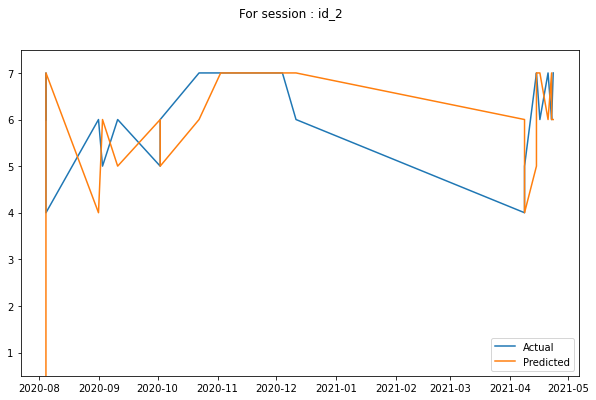

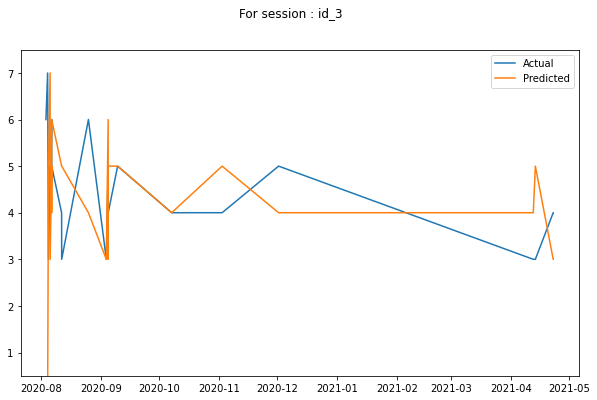

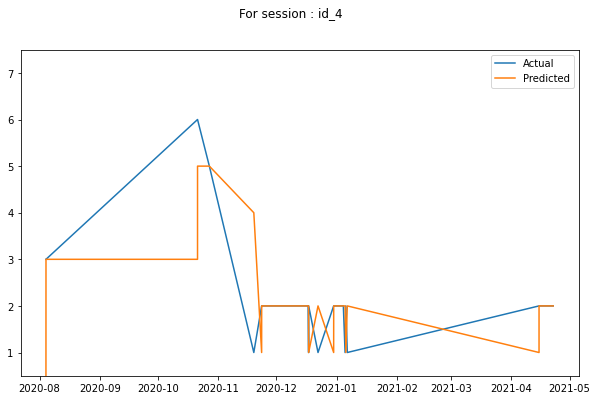

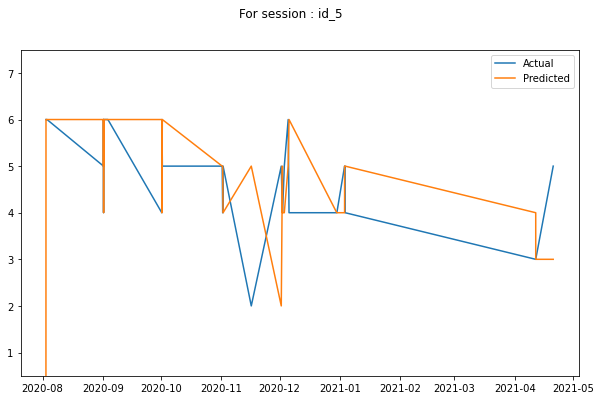

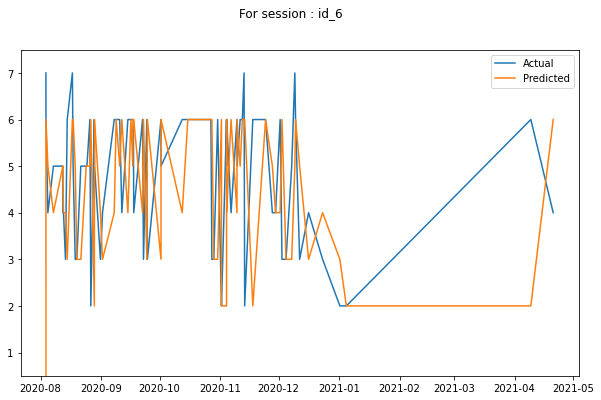

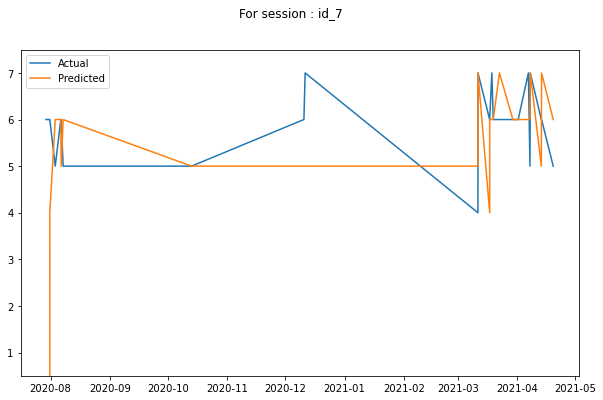

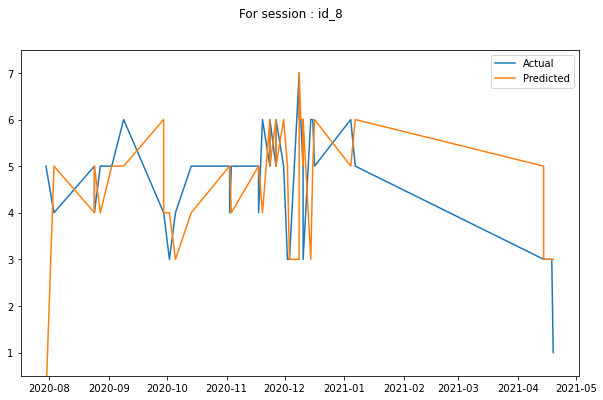

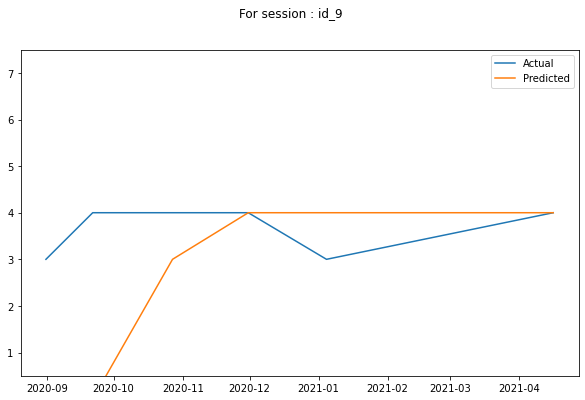

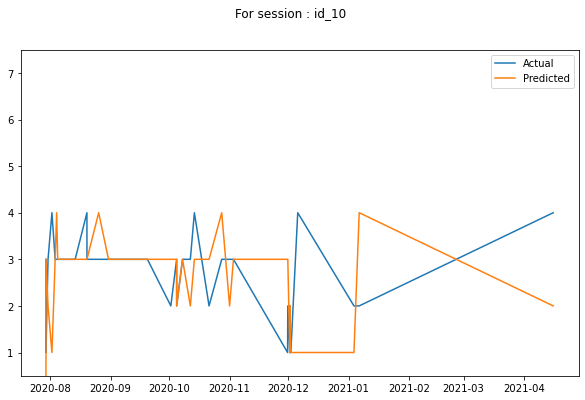

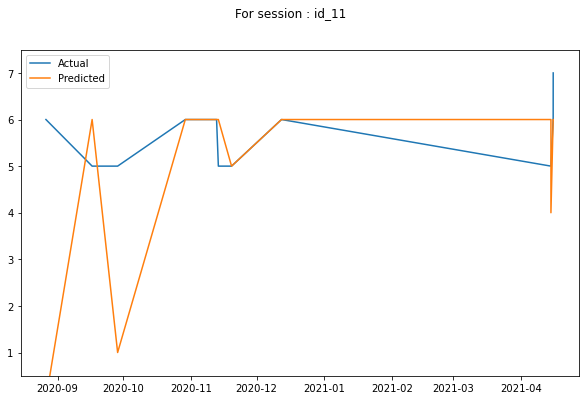

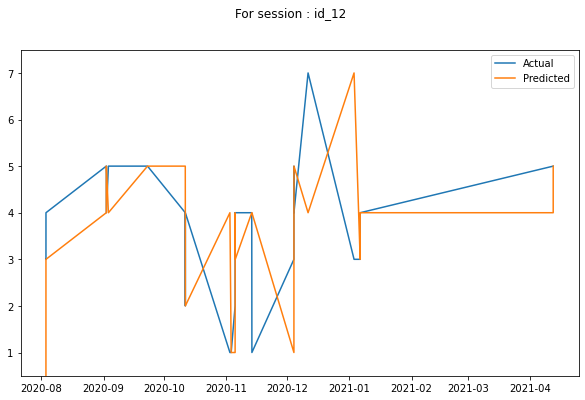

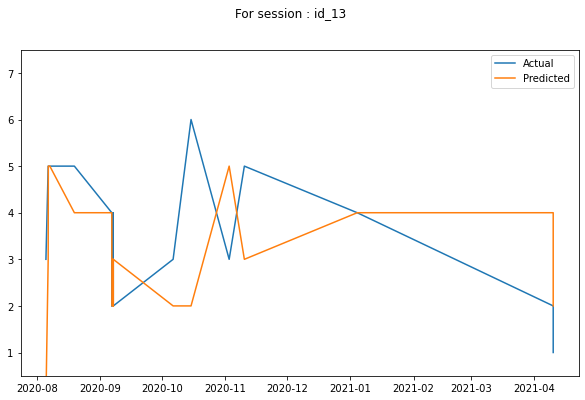

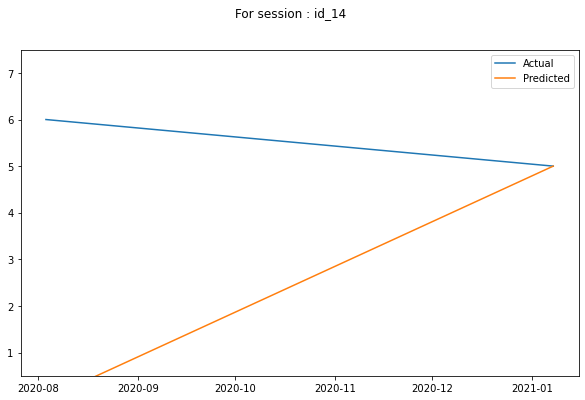

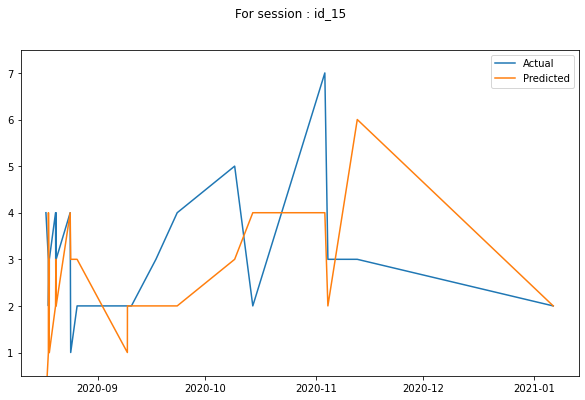

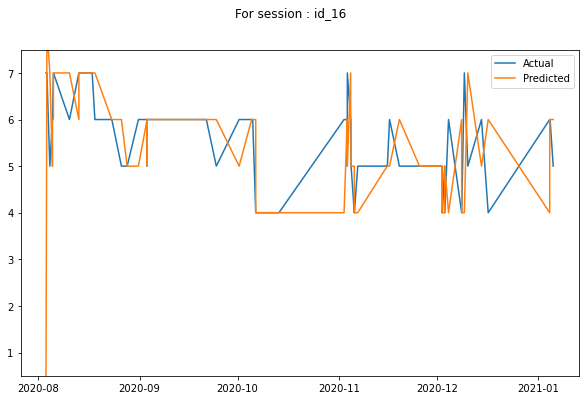

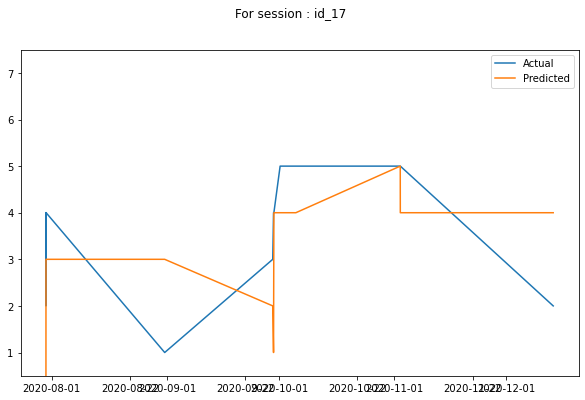

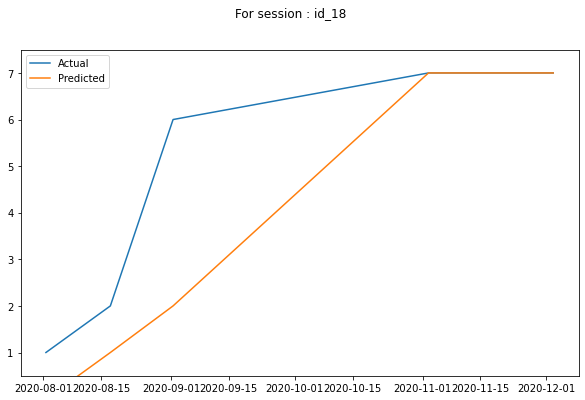

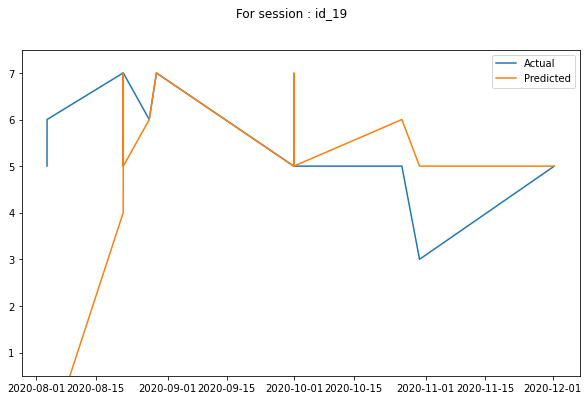

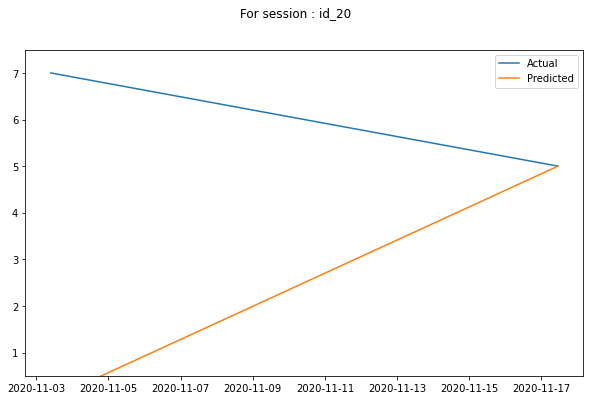

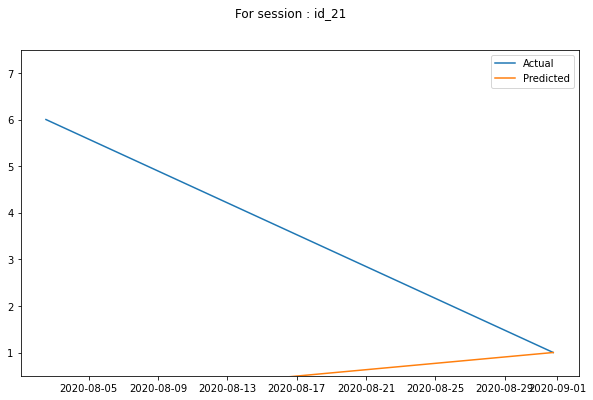

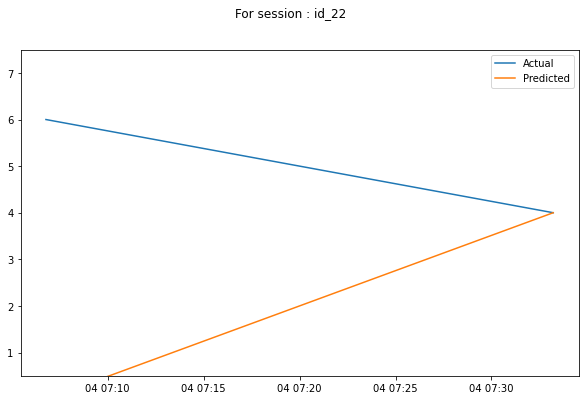

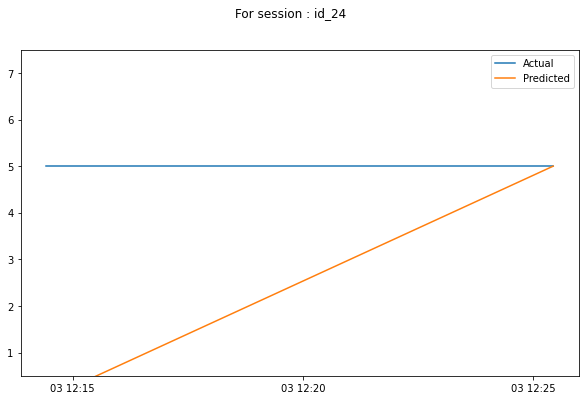

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

### 3. Facebook's Prophet

In [ ]:
def calculate_fbprophet():
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]

        input_data['ds'] = [ datetime.datetime(year=2020, month=1, day=1) + datetime.timedelta(days=index) for index in input_data.index ]
        input_data['y'] = list( input_data['battarie_energie'].astype(int) )
        prophet = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(input_data)
        
        forecast = [ np.round(x)[0] for x in prophet.predict(prophet.make_future_dataframe(periods=len(input_data)))[['yhat']].values ]
        predicted_series = [ int(np.around(x)) for x in forecast[0:len(input_data)] ]
        actual_series = list(input_data['y'].values)
        
        testScore = accuracy_score(actual_series, predicted_series)
        print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data['ended'])
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_fbprophet()

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 20.


For id:  id_1  accuracy is :  0.38095238095238093


INFO:prophet:n_changepoints greater than number of observations. Using 17.


For id:  id_2  accuracy is :  0.2962962962962963
For id:  id_3  accuracy is :  0.2608695652173913
For id:  id_4  accuracy is :  0.6938775510204082
For id:  id_5  accuracy is :  0.3


INFO:prophet:n_changepoints greater than number of observations. Using 19.


For id:  id_6  accuracy is :  0.15789473684210525
For id:  id_7  accuracy is :  0.5384615384615384


INFO:prophet:n_changepoints greater than number of observations. Using 3.


For id:  id_8  accuracy is :  0.32608695652173914
For id:  id_9  accuracy is :  0.6666666666666666


INFO:prophet:n_changepoints greater than number of observations. Using 10.


For id:  id_10  accuracy is :  0.3076923076923077
For id:  id_11  accuracy is :  0.35714285714285715


INFO:prophet:n_changepoints greater than number of observations. Using 17.


For id:  id_12  accuracy is :  0.3333333333333333


INFO:prophet:n_changepoints greater than number of observations. Using 0.


For id:  id_13  accuracy is :  0.08695652173913043


INFO:prophet:n_changepoints greater than number of observations. Using 20.


For id:  id_14  accuracy is :  0.0
For id:  id_15  accuracy is :  0.3333333333333333


INFO:prophet:n_changepoints greater than number of observations. Using 8.


For id:  id_16  accuracy is :  0.23595505617977527


INFO:prophet:n_changepoints greater than number of observations. Using 3.


For id:  id_17  accuracy is :  0.3333333333333333


INFO:prophet:n_changepoints greater than number of observations. Using 10.


For id:  id_18  accuracy is :  0.0


INFO:prophet:n_changepoints greater than number of observations. Using 0.


For id:  id_19  accuracy is :  0.21428571428571427


INFO:prophet:n_changepoints greater than number of observations. Using 0.


For id:  id_20  accuracy is :  0.0


INFO:prophet:n_changepoints greater than number of observations. Using 0.


For id:  id_21  accuracy is :  0.0


INFO:prophet:n_changepoints greater than number of observations. Using 0.


For id:  id_22  accuracy is :  0.0
For id:  id_24  accuracy is :  1.0


Average accuracy via Facebook Prophet is :  0.2966581803921004
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.47      0.58      0.52        60
           3       0.24      0.29      0.27        65
           4       0.41      0.30      0.35       128
           5       0.35      0.23      0.28       193
           6       0.32      0.34      0.33       131
           7       0.00      0.00      0.00         1
           8       1.00      0.00      0.00         1

    accuracy                           0.31       580
   macro avg       0.35      0.22      0.22       580
weighted avg       0.36      0.31      0.33       580



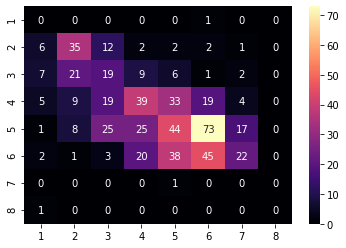

In [ ]:
print('Average accuracy via Facebook Prophet is : ', sum(accuracies)/len(accuracies))

true_all = np.hstack(list(actual_values.values()))
preds_all = np.hstack(list(predicted_values.values()))
classification_reports_all['FProphet'] = classification_report(preds_all , true_all, zero_division=True)

unique_pred = list( set( list(set(preds_all)) + list(set(true_all)) ) )
unique_pred.sort()
cmatrix = pandas.DataFrame(confusion_matrix(preds_all , true_all), columns=unique_pred)
cmatrix.index = unique_pred
_ = sns.heatmap(cmatrix, cmap="magma" , annot = True)
print(classification_reports_all['FProphet'])
accuracies_global['FProphet'] = accuracies

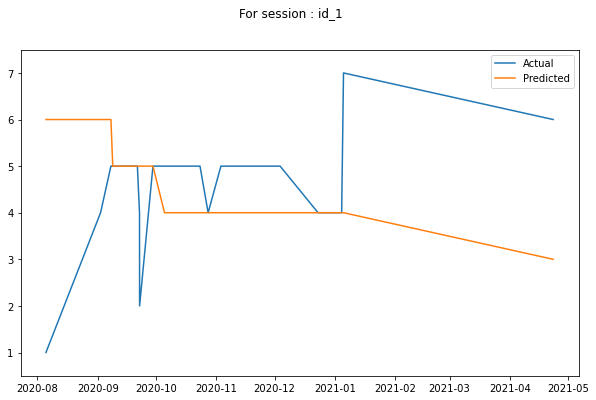

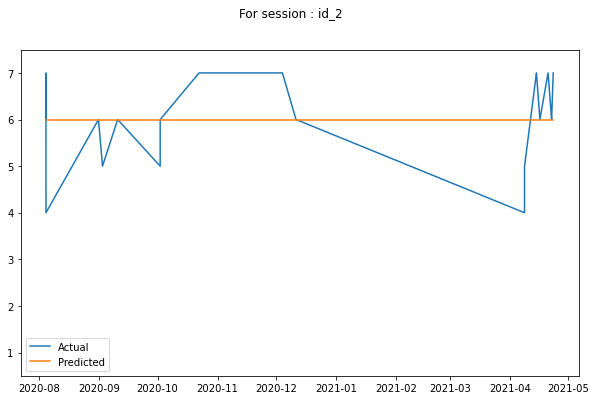

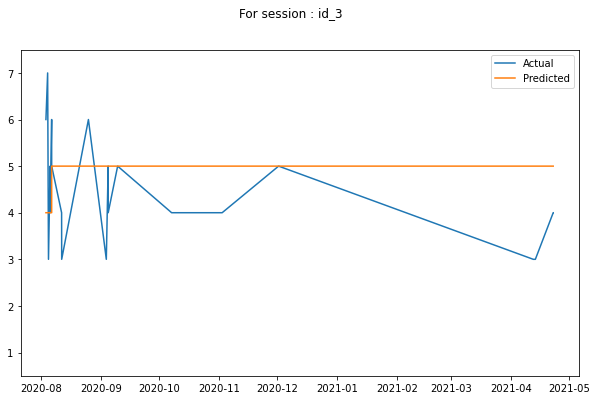

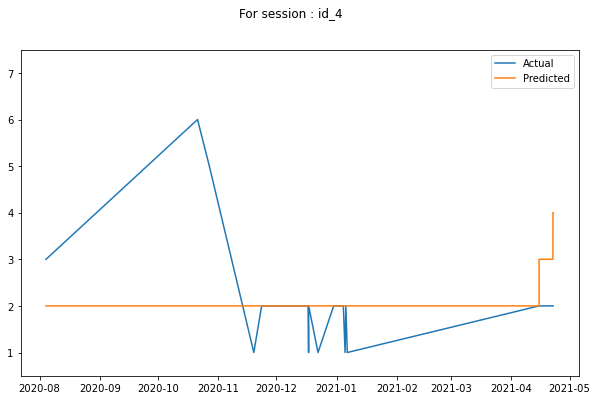

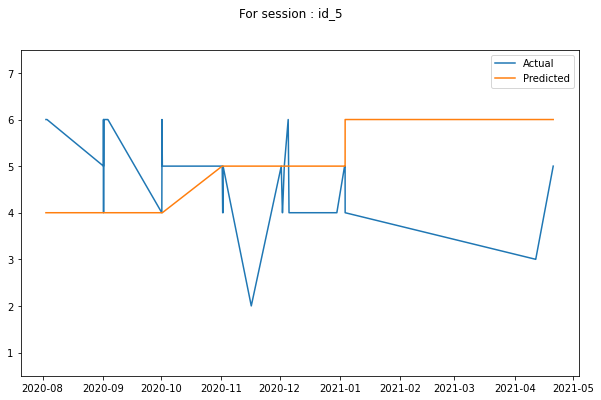

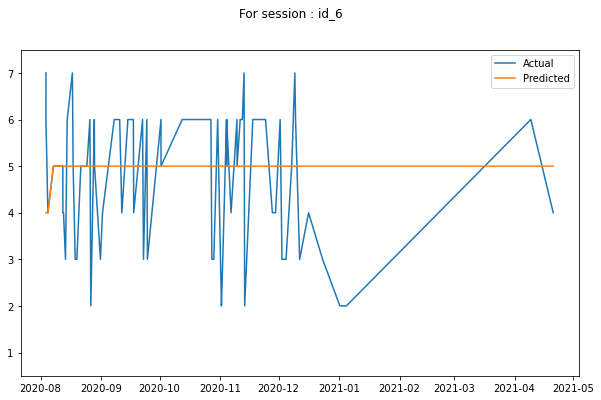

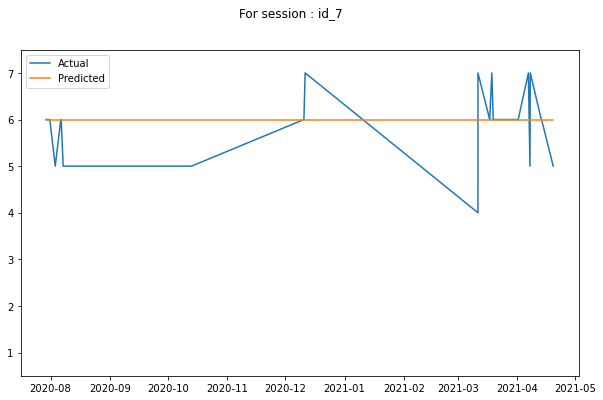

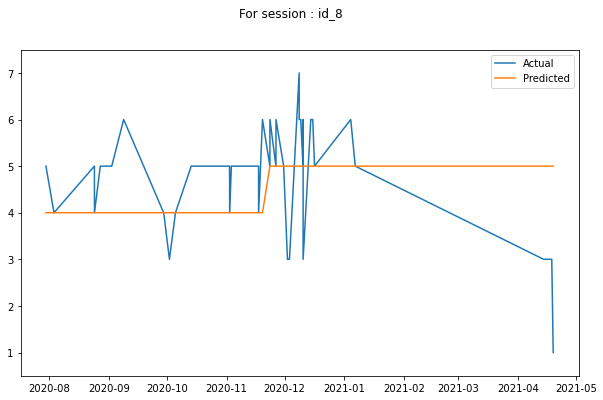

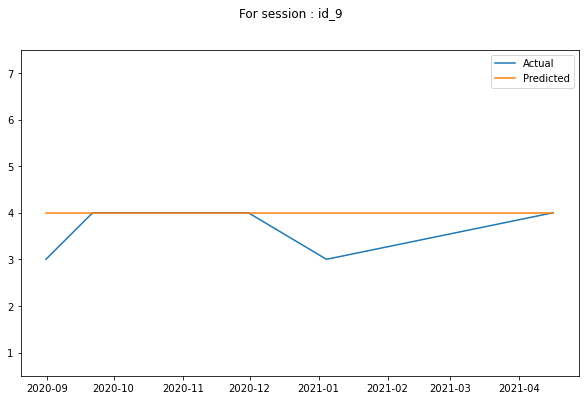

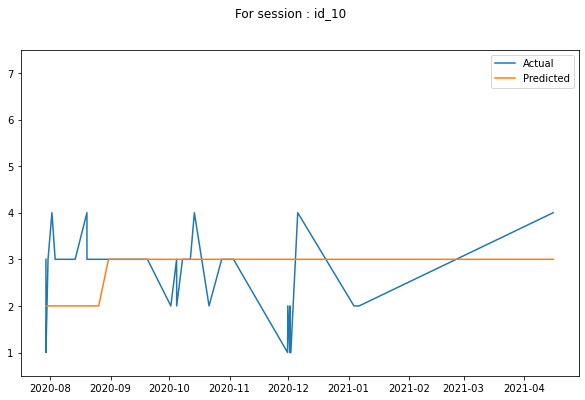

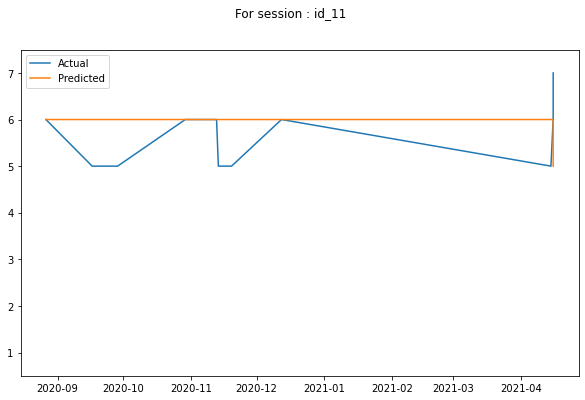

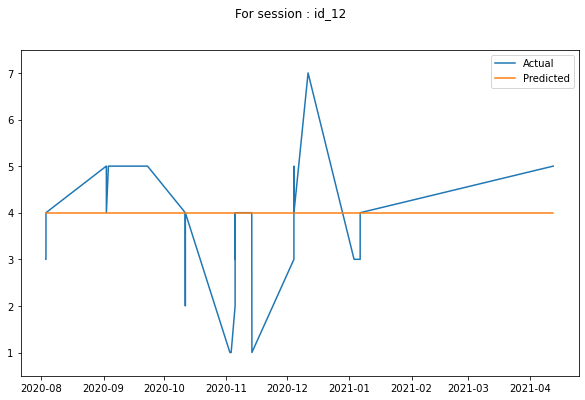

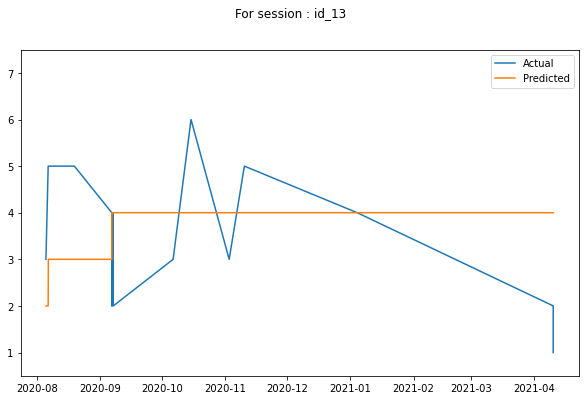

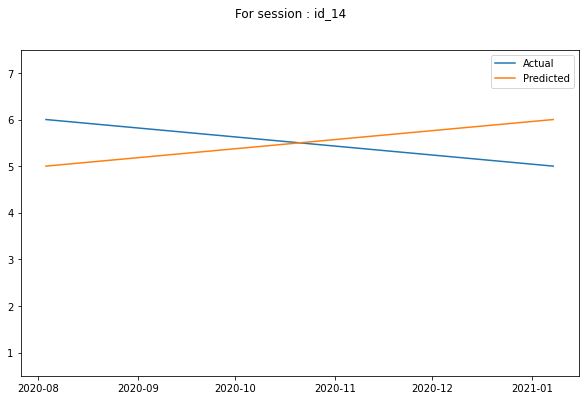

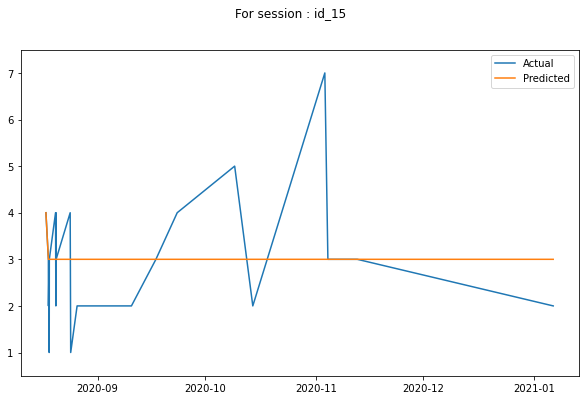

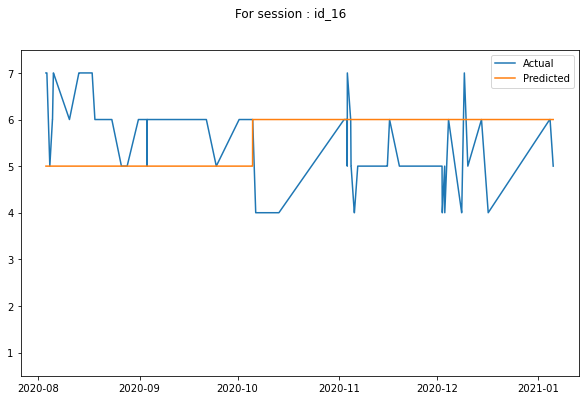

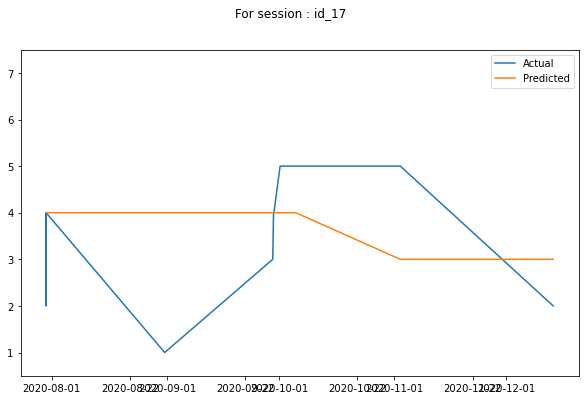

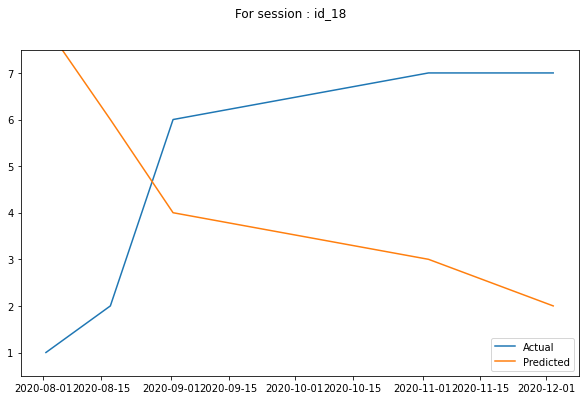

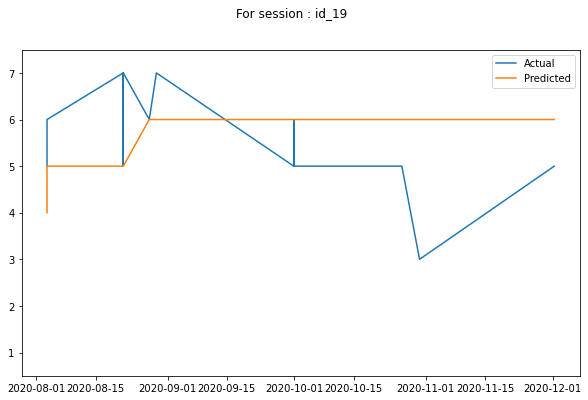

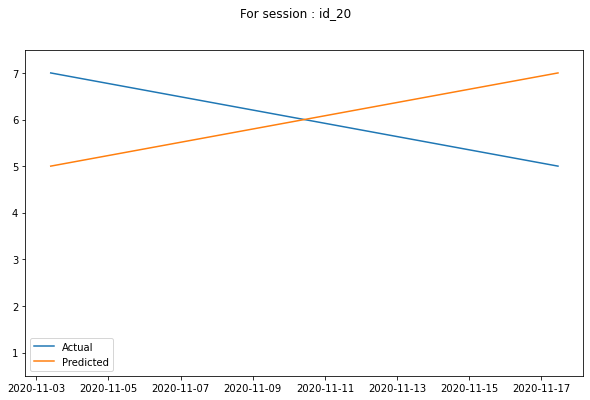

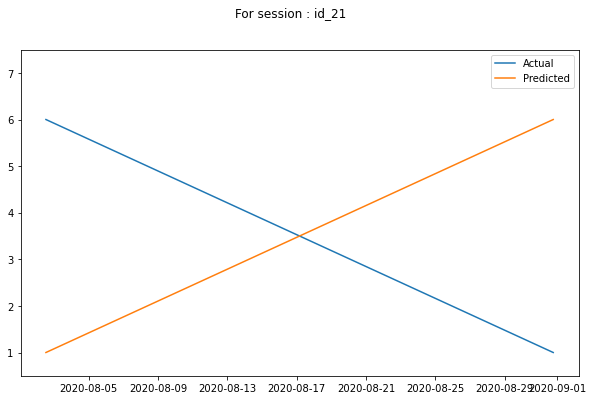

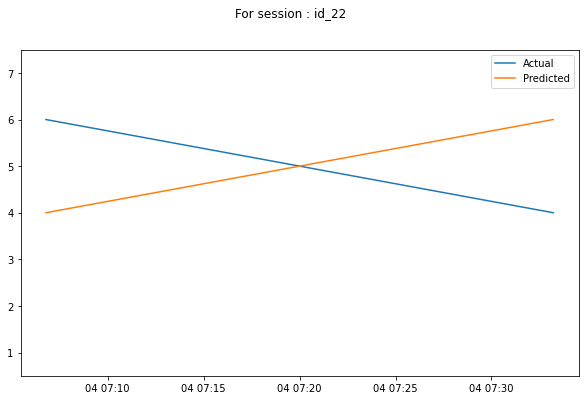

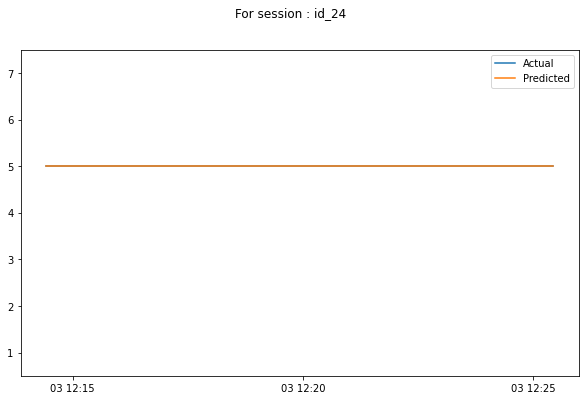

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

### 4. Winter Holtz method

In [ ]:
def calculate_winter_holtz(sp=2, seasonal='add', trend='add', log=True):
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]
        actual_series = list( input_data['battarie_energie'].astype(int) )
        
        if len(actual_series) <= sp:
            continue
        
        try:
            predicted_series = ExponentialSmoothing(actual_series, seasonal_periods=sp, seasonal=seasonal, trend=trend).fit().fittedvalues
        except:
            continue

        predicted_series = [ int(np.round(x)) for x in predicted_series ]
        
        testScore = accuracy_score(actual_series, predicted_series)
        if log:
            print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data['ended'])
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
for seasonal in ['add', 'mult']:
    for trend in ['add', 'mult']:
        for sp in [2,3]:
            accuracies, timestamps, actual_values, predicted_values = calculate_winter_holtz(sp, 'add', 'add', log=False)
            print('Average accuracy for Expontential Winter Holtz method for period : {}, seasonal : {} and trend : {} is : {}'.format(
                sp, seasonal, trend, sum(accuracies)/len(accuracies)))

Average accuracy for Expontential Winter Holtz method for period : 2, seasonal : add and trend : add is : 0.41526876232623156
Average accuracy for Expontential Winter Holtz method for period : 3, seasonal : add and trend : add is : 0.4542716475447992
Average accuracy for Expontential Winter Holtz method for period : 2, seasonal : add and trend : mult is : 0.41526876232623156
Average accuracy for Expontential Winter Holtz method for period : 3, seasonal : add and trend : mult is : 0.4542716475447992
Average accuracy for Expontential Winter Holtz method for period : 2, seasonal : mult and trend : add is : 0.41526876232623156
Average accuracy for Expontential Winter Holtz method for period : 3, seasonal : mult and trend : add is : 0.4542716475447992
Average accuracy for Expontential Winter Holtz method for period : 2, seasonal : mult and trend : mult is : 0.41526876232623156
Average accuracy for Expontential Winter Holtz method for period : 3, seasonal : mult and trend : mult is : 0.45427

In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_winter_holtz(sp=3)

For id:  id_1  accuracy is :  0.23809523809523808
For id:  id_2  accuracy is :  0.37037037037037035
For id:  id_3  accuracy is :  0.5217391304347826
For id:  id_4  accuracy is :  0.7551020408163265
For id:  id_5  accuracy is :  0.5
For id:  id_6  accuracy is :  0.15789473684210525
For id:  id_7  accuracy is :  0.5384615384615384
For id:  id_8  accuracy is :  0.2391304347826087
For id:  id_9  accuracy is :  0.5
For id:  id_10  accuracy is :  0.48717948717948717
For id:  id_11  accuracy is :  0.7142857142857143
For id:  id_12  accuracy is :  0.5151515151515151
For id:  id_13  accuracy is :  0.391304347826087
For id:  id_15  accuracy is :  0.25925925925925924
For id:  id_16  accuracy is :  0.6179775280898876
For id:  id_17  accuracy is :  0.4166666666666667
For id:  id_19  accuracy is :  0.5


Average accuracy via Winter Holtz method is :  0.4542716475447992
              precision    recall  f1-score   support

           1       0.05      0.14      0.07         7
           2       0.56      0.69      0.62        59
           3       0.45      0.43      0.44        82
           4       0.38      0.36      0.37       101
           5       0.50      0.33      0.40       180
           6       0.49      0.57      0.53       118
           7       0.30      0.72      0.43        18

    accuracy                           0.45       565
   macro avg       0.39      0.46      0.41       565
weighted avg       0.46      0.45      0.45       565



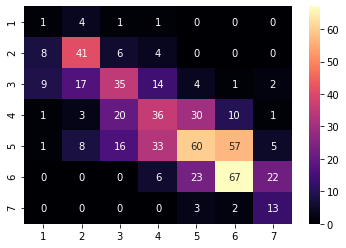

In [ ]:
print('Average accuracy via Winter Holtz method is : ', sum(accuracies)/len(accuracies))

true_all = np.hstack(list(actual_values.values()))
preds_all = np.hstack(list(predicted_values.values()))
classification_reports_all['WinterHoltz'] = classification_report(preds_all , true_all, zero_division=True)

unique_pred = list( set( list(set(preds_all)) + list(set(true_all)) ) )
unique_pred.sort()
cmatrix = pandas.DataFrame(confusion_matrix(preds_all , true_all), columns=unique_pred)
cmatrix.index = unique_pred
_ = sns.heatmap(cmatrix, cmap="magma" , annot = True)
print(classification_reports_all['WinterHoltz'])
accuracies_global['WinterHoltz'] = accuracies

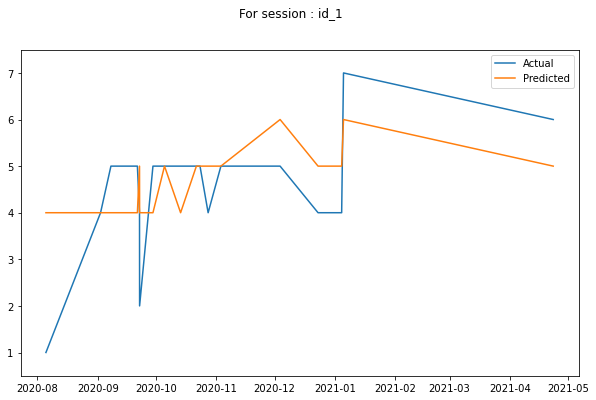

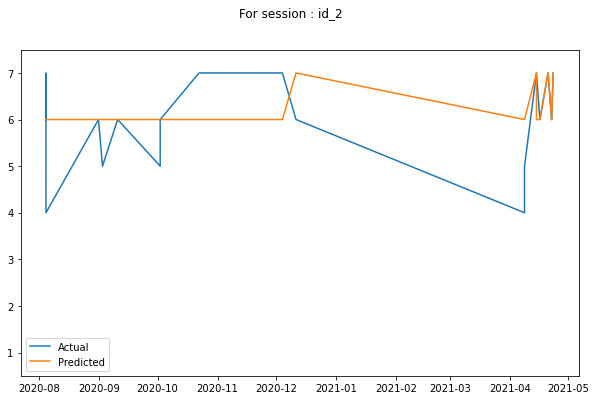

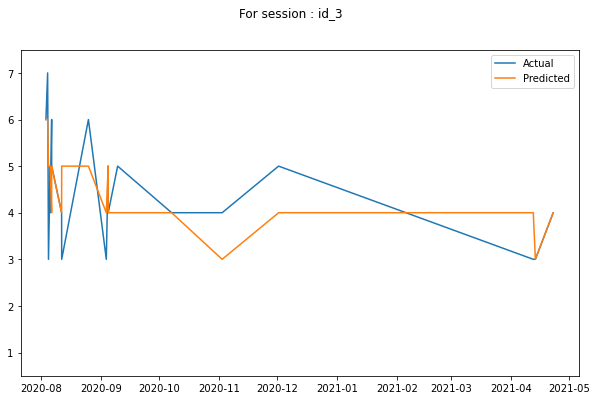

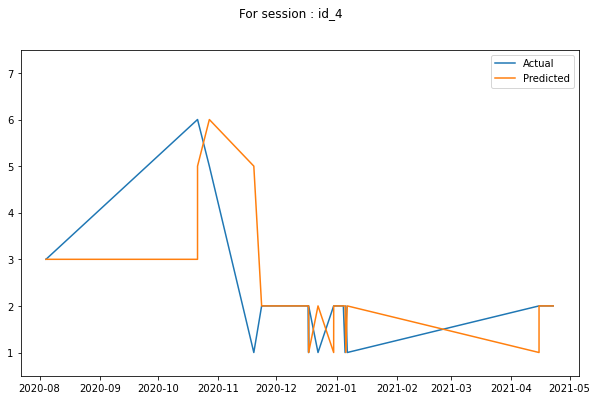

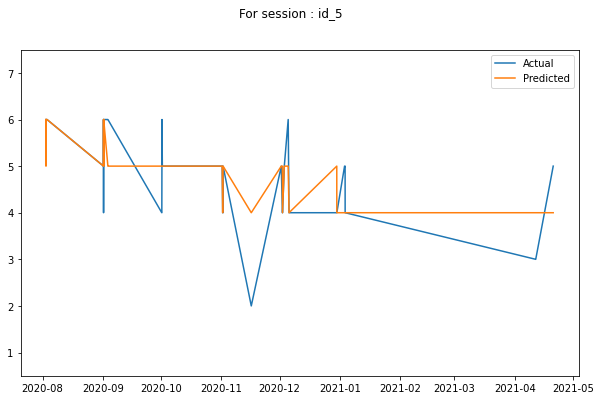

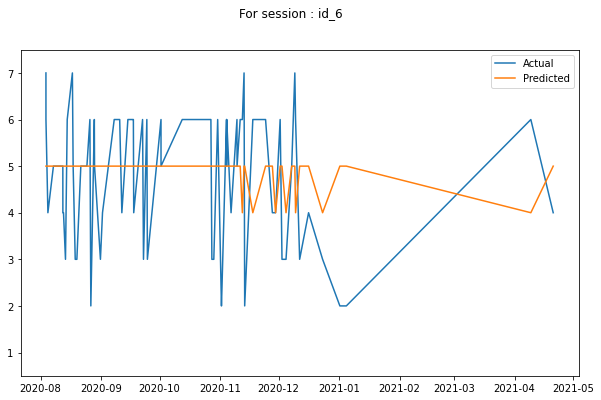

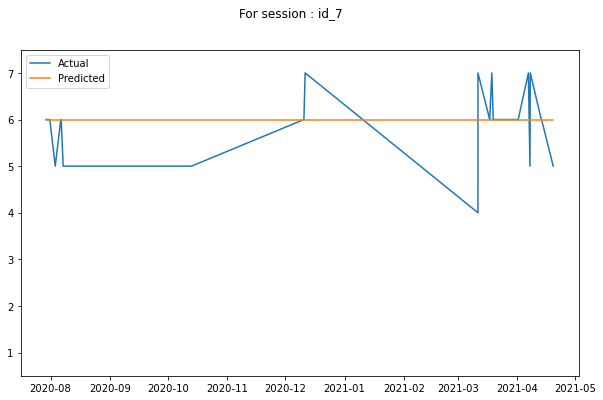

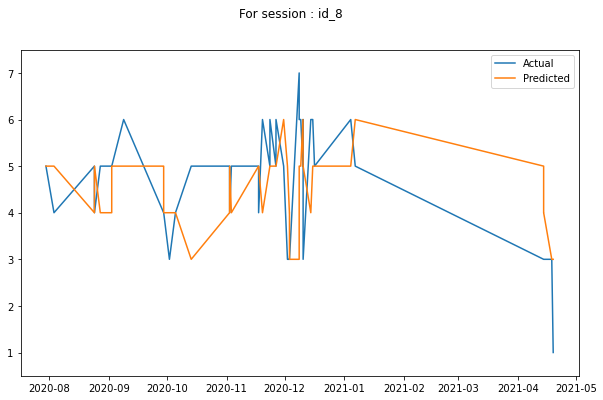

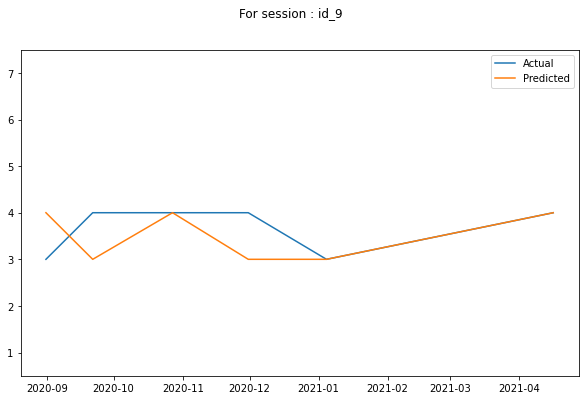

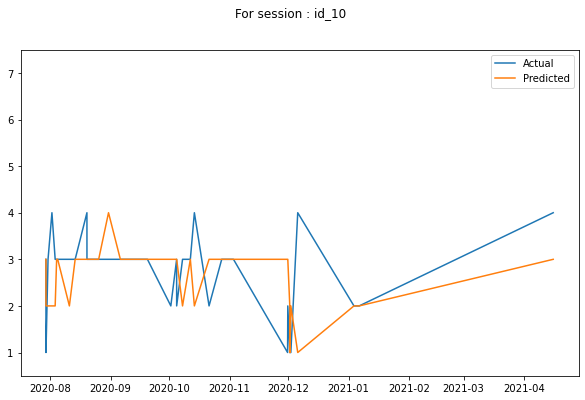

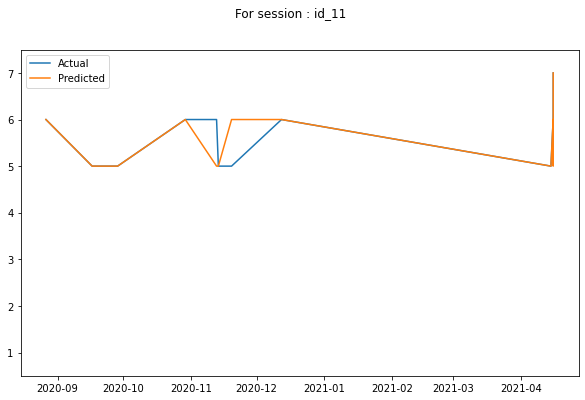

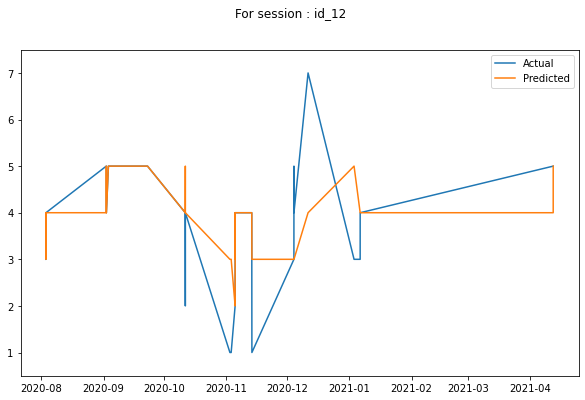

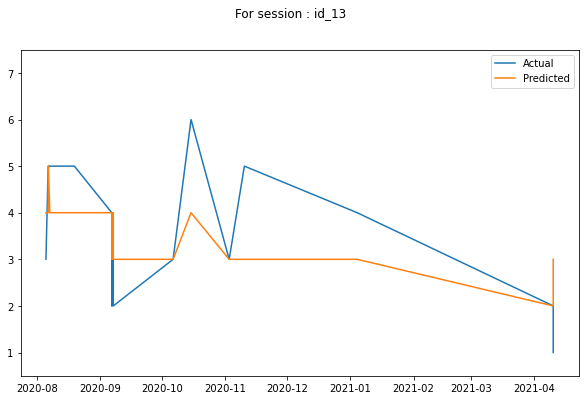

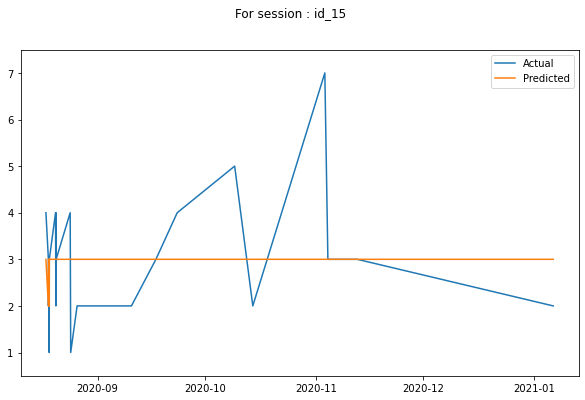

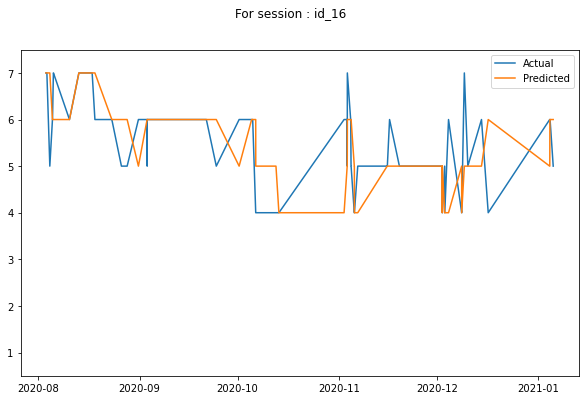

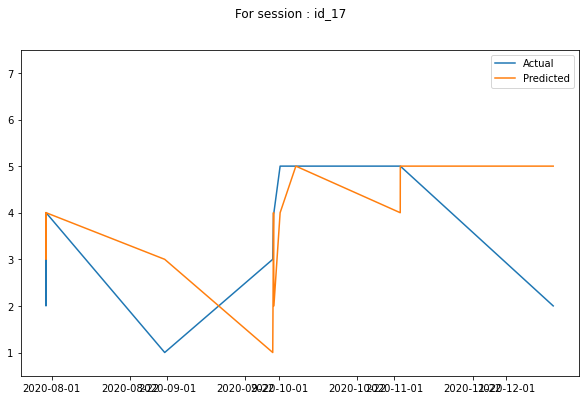

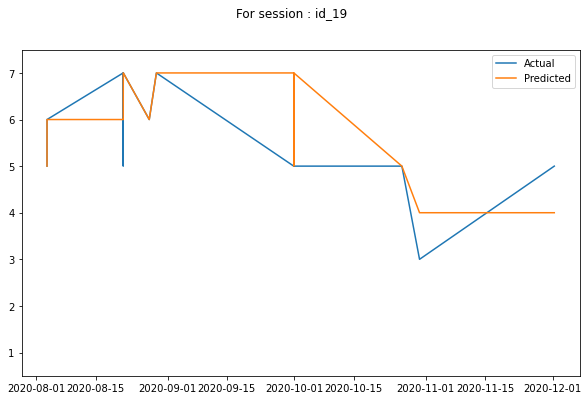

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

### 5. Simple Moving Averages

In [ ]:
def calculate_simple_moving_average(window_size=2, log=True):
    def moving_average(x, w):
        complete = np.convolve(x, np.ones(w), 'valid') / w
        full = [x[0]]
        for i in range(w-2):
            full.append( np.mean(np.array(full)) )
        full.extend(complete)
        return full
    
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]
        actual_series = list(input_data['battarie_energie'].astype(int))
        
        if len(actual_series ) < window_size:
            continue
        
        predicted_series = [ int(np.round(x)) for x in moving_average(actual_series, window_size) ]
        
        testScore = accuracy_score(actual_series, predicted_series)
        if log:
            print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data['ended'])
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
for windowsize in [2,3,4,5]:
    accuracies, timestamps, actual_values, predicted_values = calculate_simple_moving_average(windowsize, log=False)
    print('Average accuracy for SMA method for window size {} is {}'.format(windowsize, sum(accuracies)/len(accuracies)))

Average accuracy for SMA method for window size 2 is 0.6117204742527396
Average accuracy for SMA method for window size 3 is 0.5361952914223103
Average accuracy for SMA method for window size 4 is 0.48434382474392124
Average accuracy for SMA method for window size 5 is 0.44659401226423334


In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_simple_moving_average(2)

For id:  id_1  accuracy is :  0.7142857142857143
For id:  id_2  accuracy is :  0.5925925925925926
For id:  id_3  accuracy is :  0.4782608695652174
For id:  id_4  accuracy is :  0.8571428571428571
For id:  id_5  accuracy is :  0.65
For id:  id_6  accuracy is :  0.4473684210526316
For id:  id_7  accuracy is :  0.6153846153846154
For id:  id_8  accuracy is :  0.5869565217391305
For id:  id_9  accuracy is :  0.8333333333333334
For id:  id_10  accuracy is :  0.6410256410256411
For id:  id_11  accuracy is :  0.7142857142857143
For id:  id_12  accuracy is :  0.6060606060606061
For id:  id_13  accuracy is :  0.5217391304347826
For id:  id_14  accuracy is :  0.5
For id:  id_15  accuracy is :  0.5185185185185185
For id:  id_16  accuracy is :  0.7640449438202247
For id:  id_17  accuracy is :  0.5
For id:  id_18  accuracy is :  0.6
For id:  id_19  accuracy is :  0.42857142857142855
For id:  id_20  accuracy is :  0.5
For id:  id_21  accuracy is :  0.5
For id:  id_22  accuracy is :  0.5
For id:  id_

Average accuracy via simple MA method is :  0.6117204742527396
              precision    recall  f1-score   support

           1       0.23      1.00      0.37         5
           2       0.82      0.69      0.75        89
           3       0.47      0.73      0.57        51
           4       0.74      0.47      0.57       150
           5       0.44      0.64      0.52        85
           6       0.82      0.64      0.72       181
           7       0.41      1.00      0.58        19

    accuracy                           0.62       580
   macro avg       0.56      0.74      0.58       580
weighted avg       0.69      0.62      0.64       580



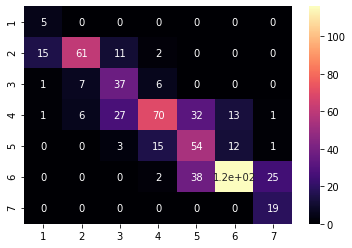

In [ ]:
print('Average accuracy via simple MA method is : ', sum(accuracies)/len(accuracies))

true_all = np.hstack(list(actual_values.values()))
preds_all = np.hstack(list(predicted_values.values()))
classification_reports_all['MA'] = classification_report(preds_all , true_all, zero_division=True)

unique_pred = list( set( list(set(preds_all)) + list(set(true_all)) ) )
unique_pred.sort()
cmatrix = pandas.DataFrame(confusion_matrix(preds_all , true_all), columns=unique_pred)
cmatrix.index = unique_pred
_ = sns.heatmap(cmatrix, cmap="magma" , annot = True)
print(classification_reports_all['MA'])
accuracies_global['MA'] = accuracies

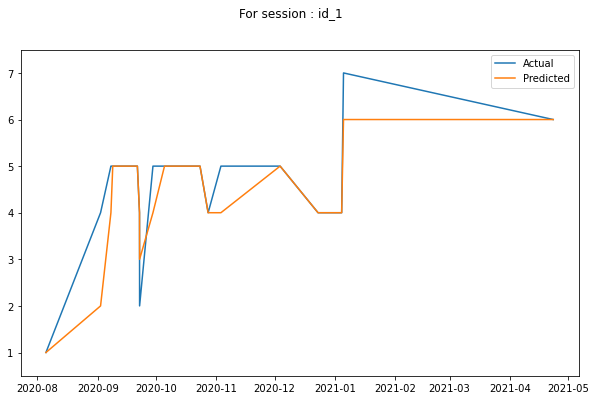

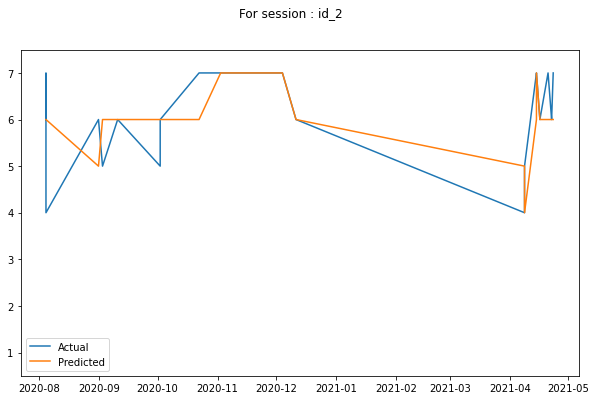

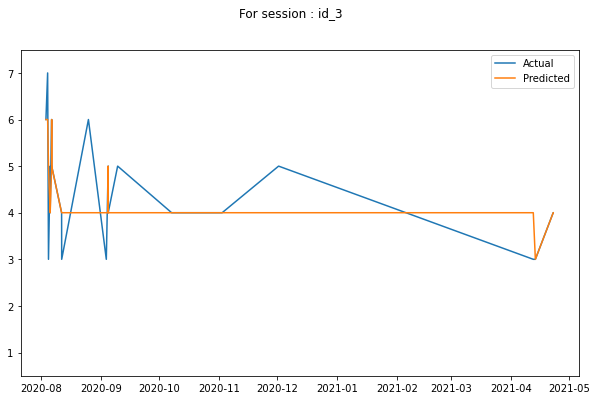

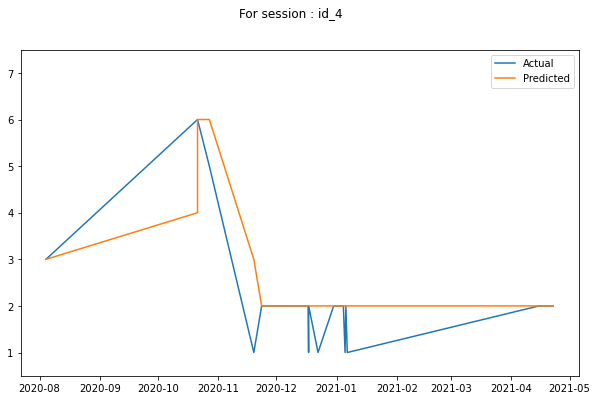

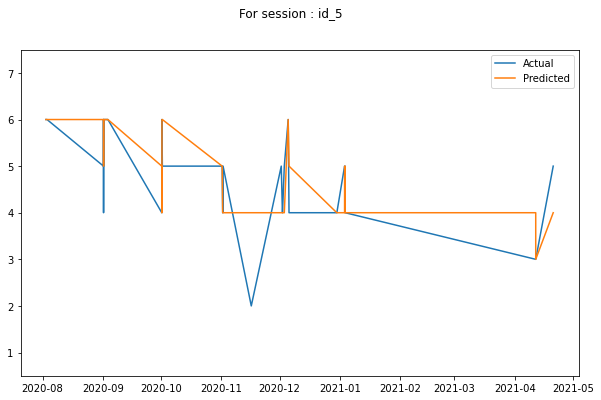

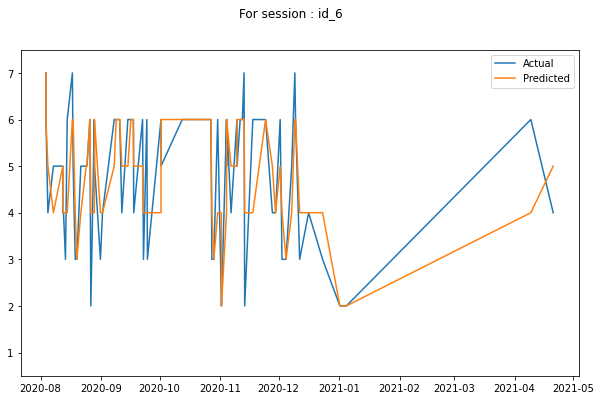

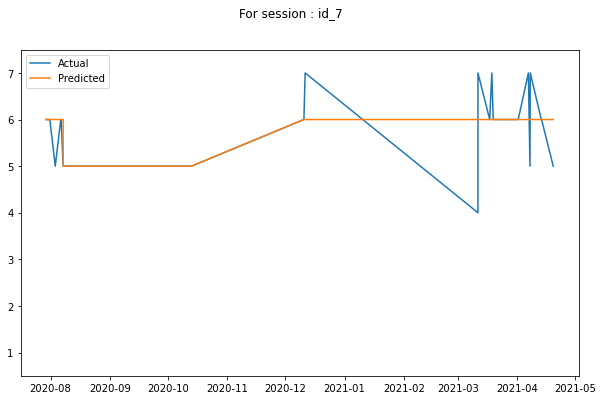

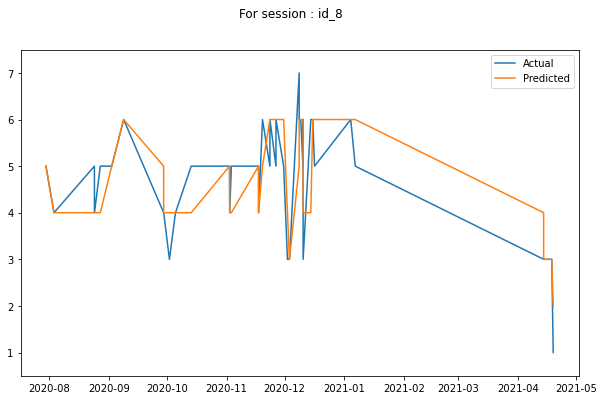

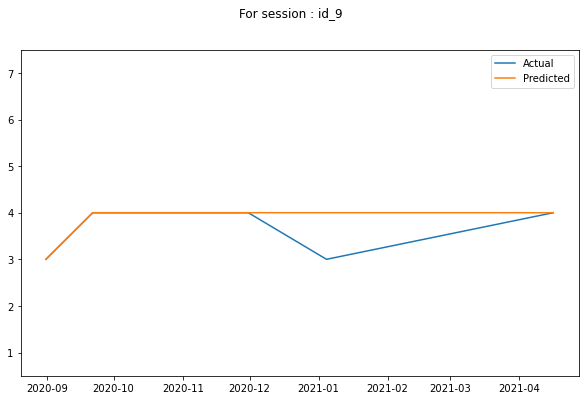

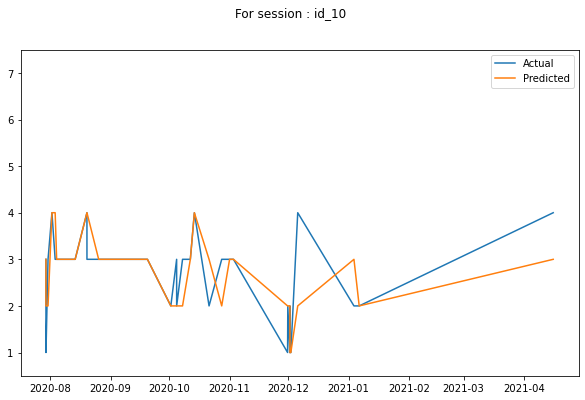

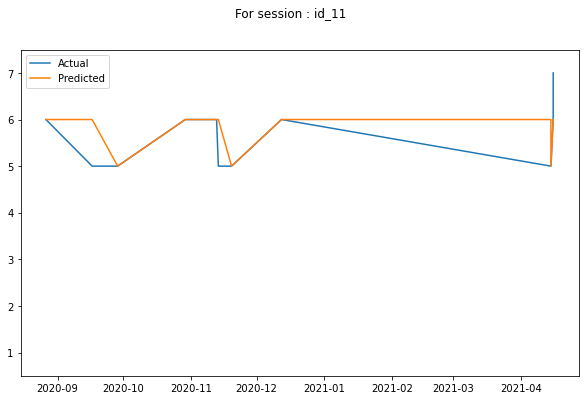

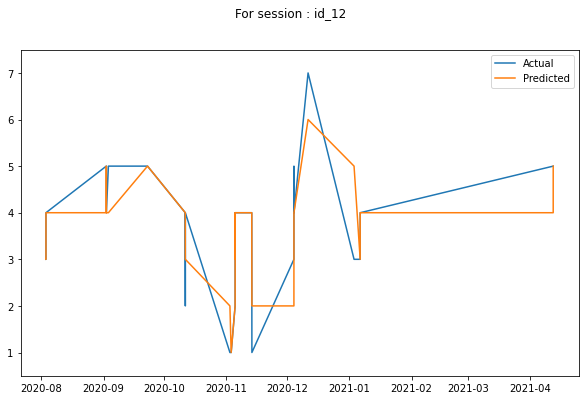

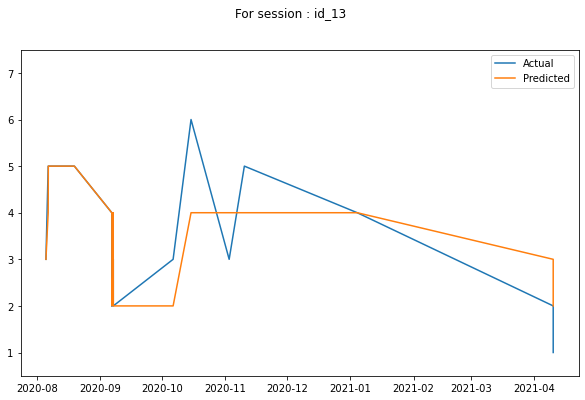

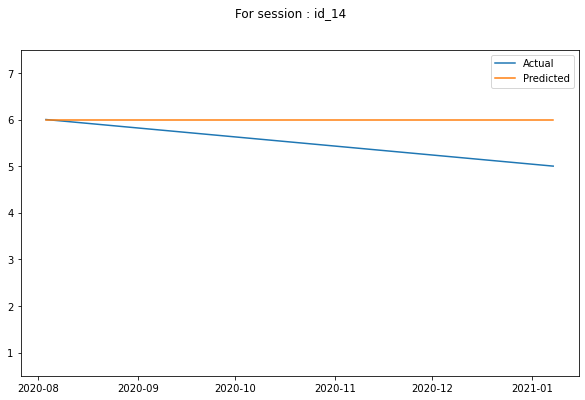

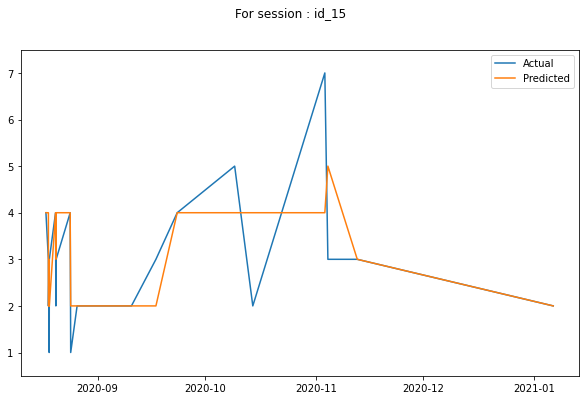

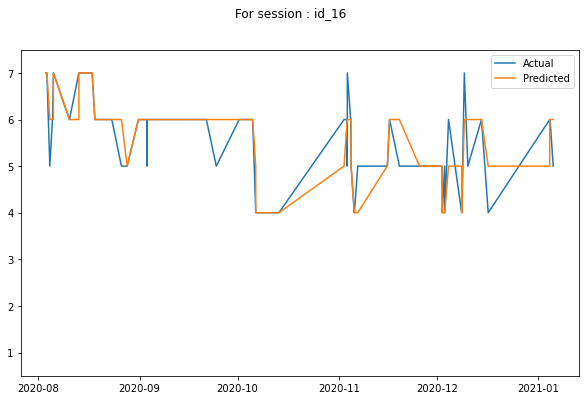

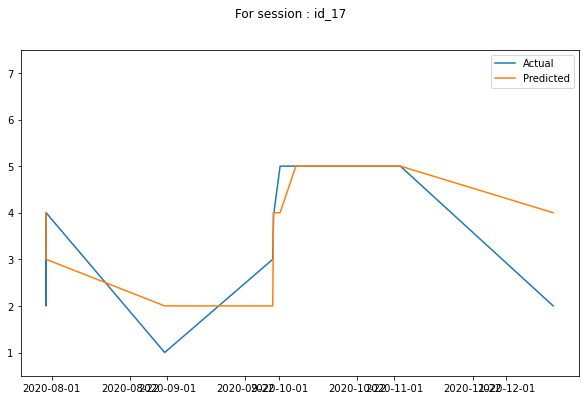

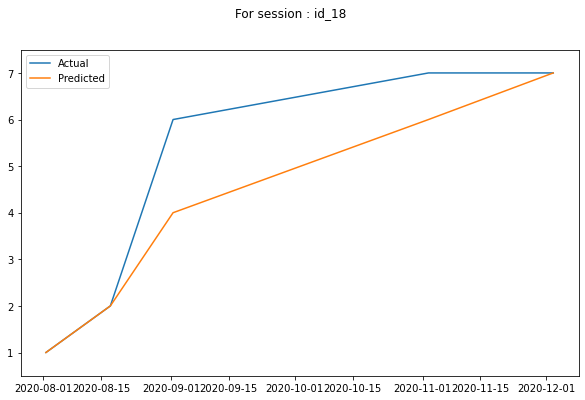

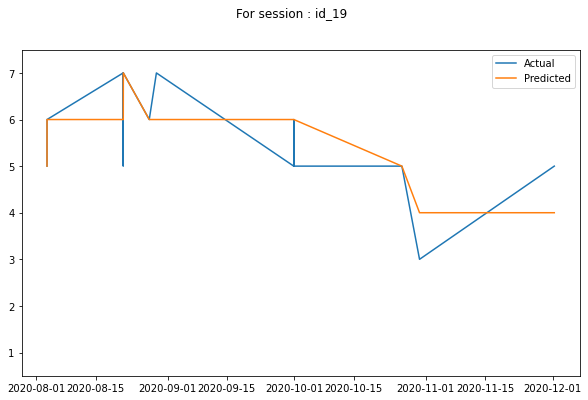

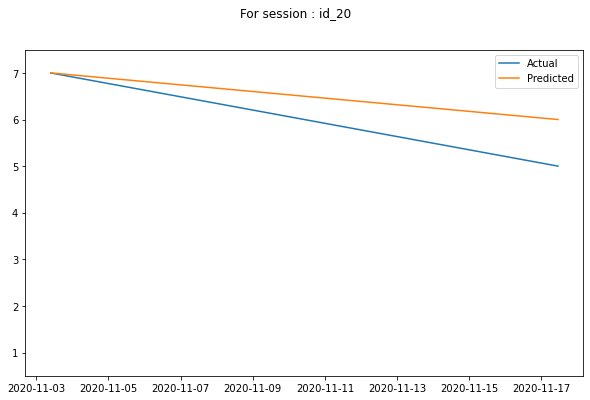

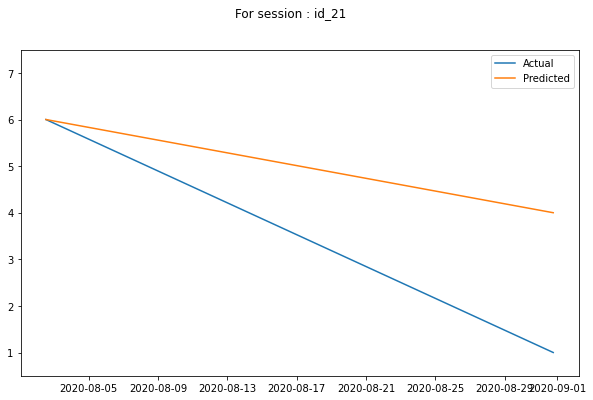

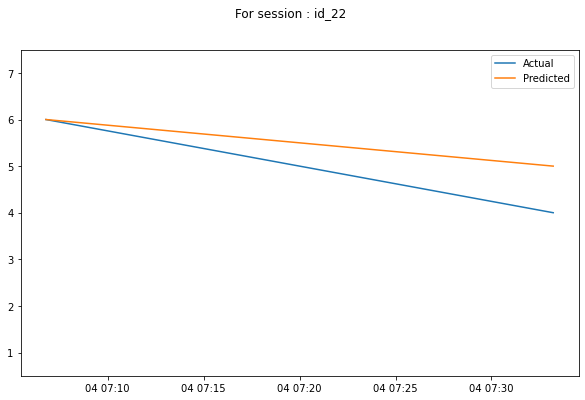

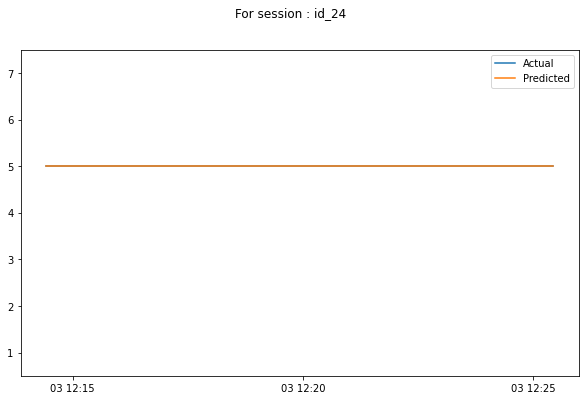

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

### 6. Exponential Moving Averages

In [ ]:
def calculate_exponential_moving_average(window_size=2, log=True):
    def ema(s, n):
        ema = [s[0]]
        multiplier = 2 / float(1 + n)
        for number in s[1:]:
            ema.append( multiplier*number + (1-multiplier)*(1-ema[-1]))
        return ema
    
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]
        actual_series = list(input_data['battarie_energie'].astype(int))
        
        if len(actual_series ) < window_size:
            continue
        
        predicted_series = [ int(np.round(x)) for x in ema(actual_series, window_size) ]
        
        testScore = accuracy_score(actual_series, predicted_series)
        if log:
            print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data['ended'])
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
for windowsize in [2,3,4,5]:
    accuracies, timestamps, actual_values, predicted_values = calculate_exponential_moving_average(windowsize, log=False)
    print('Average accuracy for EMA method for window size {} is {}'.format(windowsize, sum(accuracies)/len(accuracies)))

Average accuracy for EMA method for window size 2 is 0.16863968385666392
Average accuracy for EMA method for window size 3 is 0.07053762037001053
Average accuracy for EMA method for window size 4 is 0.06350625999151421
Average accuracy for EMA method for window size 5 is 0.06350625999151421


In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_exponential_moving_average(2)

For id:  id_1  accuracy is :  0.047619047619047616
For id:  id_2  accuracy is :  0.037037037037037035
For id:  id_3  accuracy is :  0.043478260869565216
For id:  id_4  accuracy is :  0.12244897959183673
For id:  id_5  accuracy is :  0.025
For id:  id_6  accuracy is :  0.02631578947368421
For id:  id_7  accuracy is :  0.038461538461538464
For id:  id_8  accuracy is :  0.021739130434782608
For id:  id_9  accuracy is :  0.16666666666666666
For id:  id_10  accuracy is :  0.15384615384615385
For id:  id_11  accuracy is :  0.07142857142857142
For id:  id_12  accuracy is :  0.06060606060606061
For id:  id_13  accuracy is :  0.08695652173913043
For id:  id_14  accuracy is :  0.5
For id:  id_15  accuracy is :  0.1111111111111111
For id:  id_16  accuracy is :  0.011235955056179775
For id:  id_17  accuracy is :  0.08333333333333333
For id:  id_18  accuracy is :  0.2
For id:  id_19  accuracy is :  0.07142857142857142
For id:  id_20  accuracy is :  0.5
For id:  id_21  accuracy is :  0.5
For id:  id

Average accuracy via exponential MA method is :  0.16863968385666392
              precision    recall  f1-score   support

          -1       1.00      0.00      0.00         1
           0       1.00      0.00      0.00        12
           1       0.55      0.12      0.20       101
           2       0.07      0.03      0.04       162
           3       0.06      0.02      0.03       210
           4       0.02      0.03      0.02        79
           5       0.02      0.75      0.05         4
           6       0.06      1.00      0.11         8
           7       0.07      1.00      0.12         3

    accuracy                           0.07       580
   macro avg       0.32      0.33      0.06       580
weighted avg       0.16      0.07      0.06       580



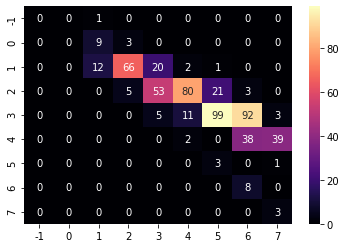

In [ ]:
print('Average accuracy via exponential MA method is : ', sum(accuracies)/len(accuracies))

true_all = np.hstack(list(actual_values.values()))
preds_all = np.hstack(list(predicted_values.values()))
classification_reports_all['EMA'] = classification_report(preds_all , true_all, zero_division=True)

unique_pred = list( set( list(set(preds_all)) + list(set(true_all)) ) )
unique_pred.sort()
cmatrix = pandas.DataFrame(confusion_matrix(preds_all , true_all), columns=unique_pred)
cmatrix.index = unique_pred
_ = sns.heatmap(cmatrix, cmap="magma" , annot = True)
print(classification_reports_all['EMA'])
accuracies_global['EMA'] = accuracies

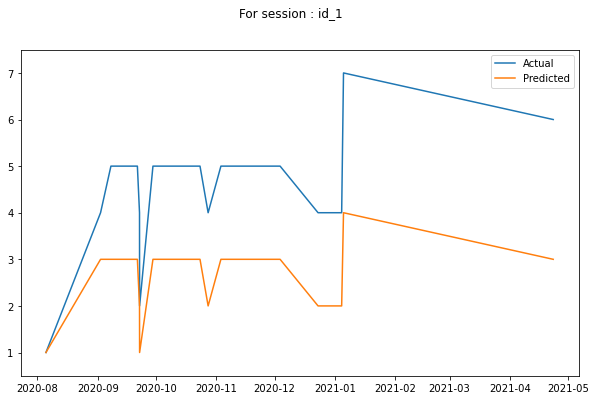

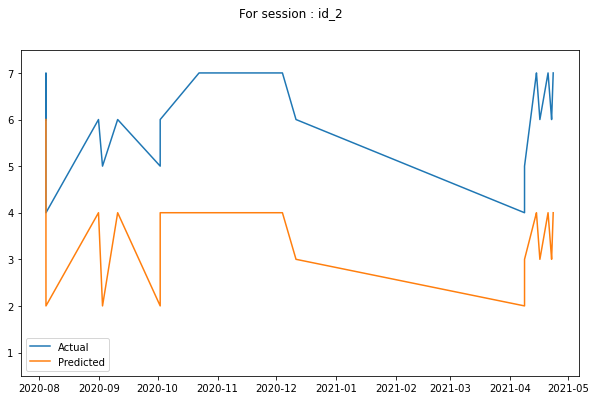

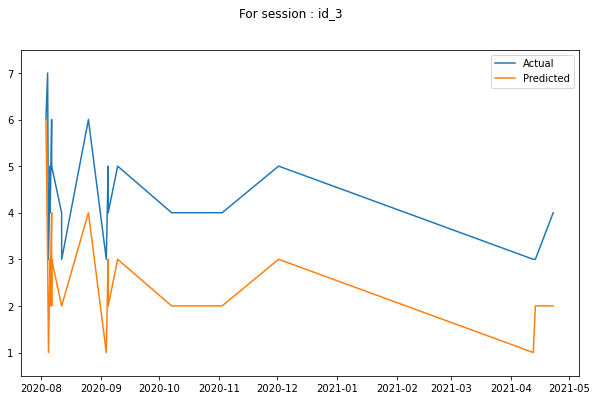

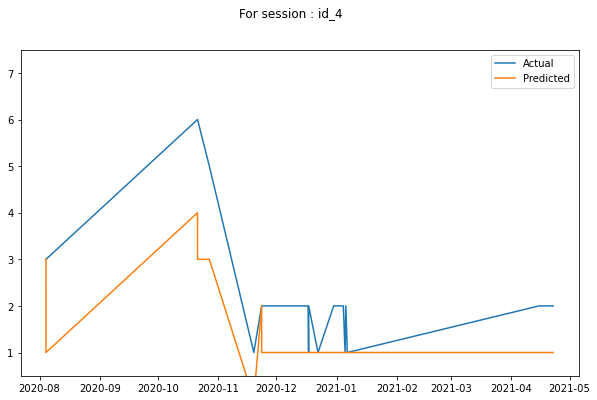

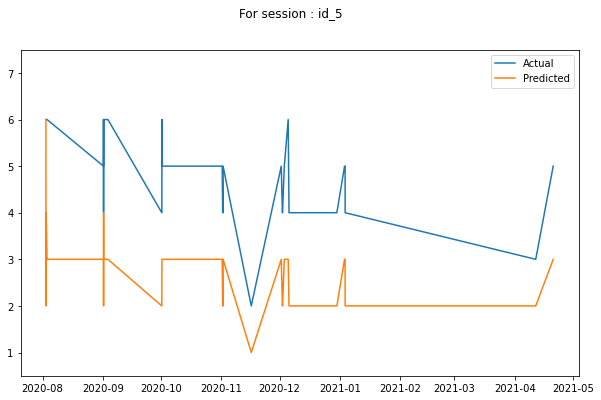

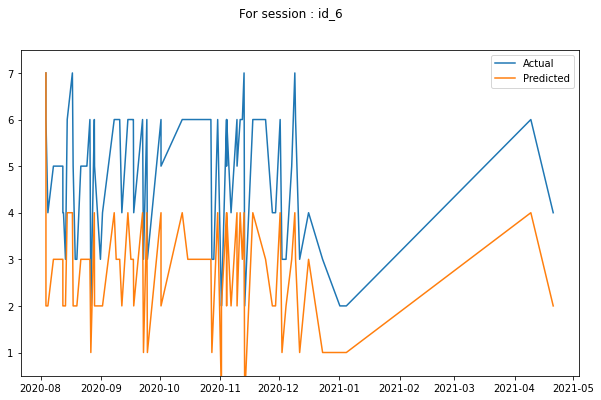

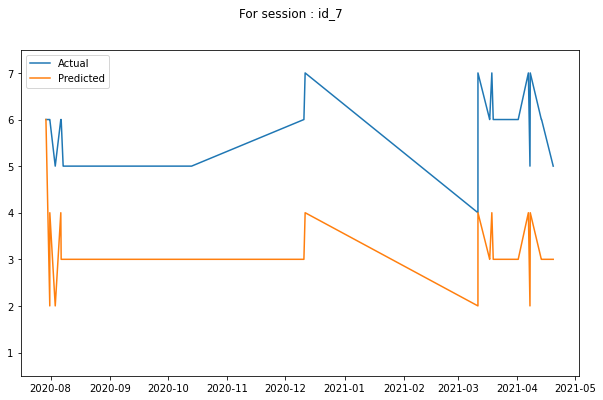

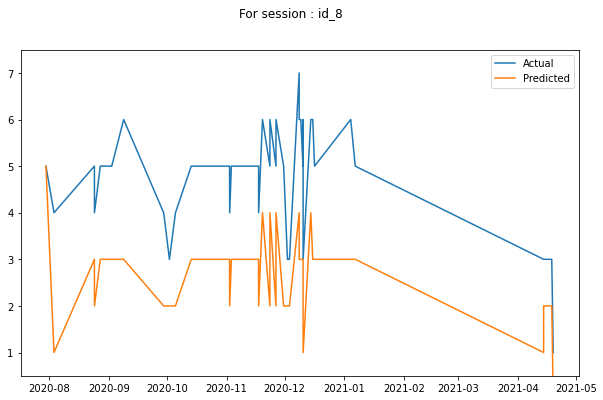

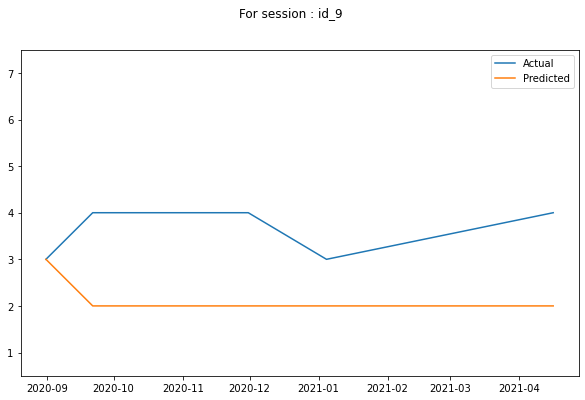

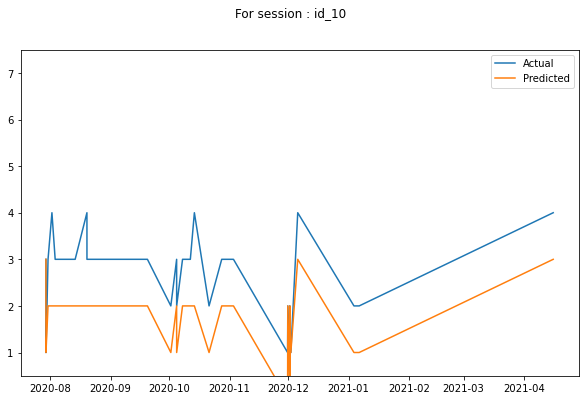

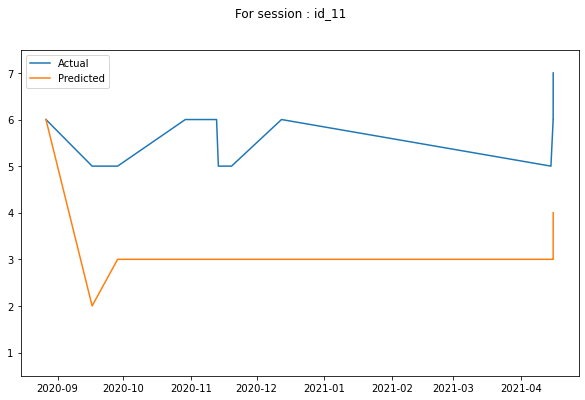

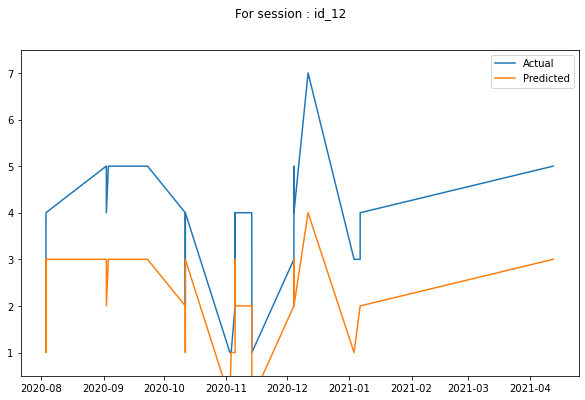

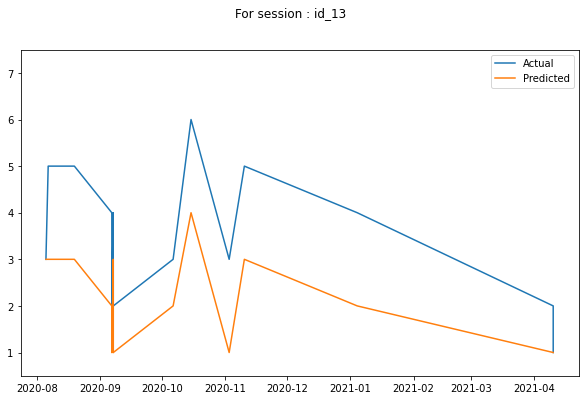

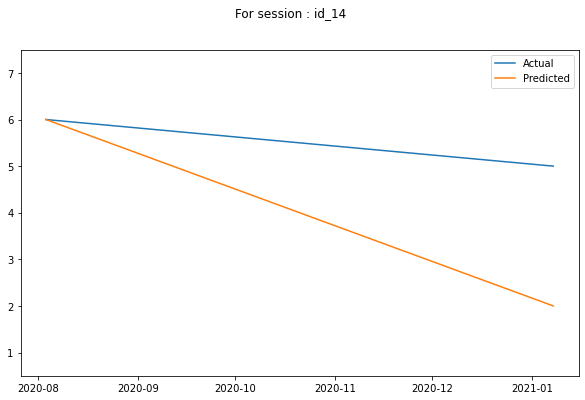

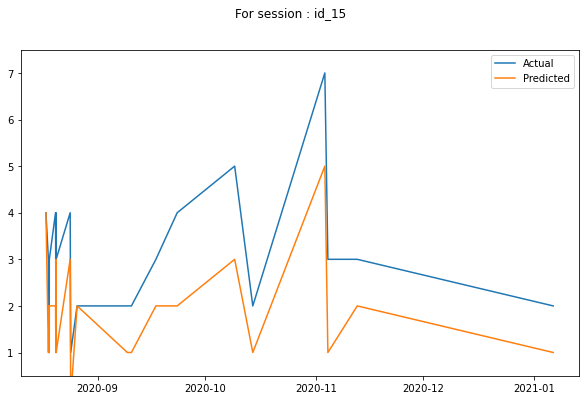

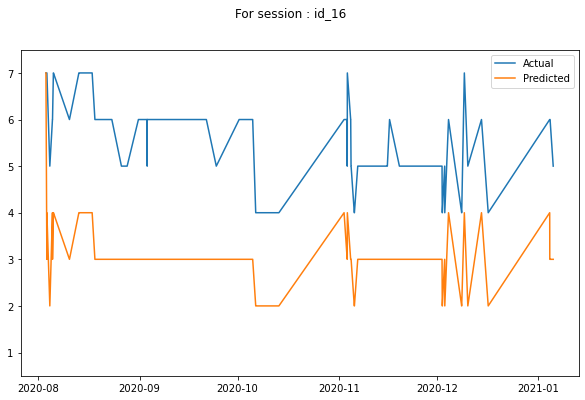

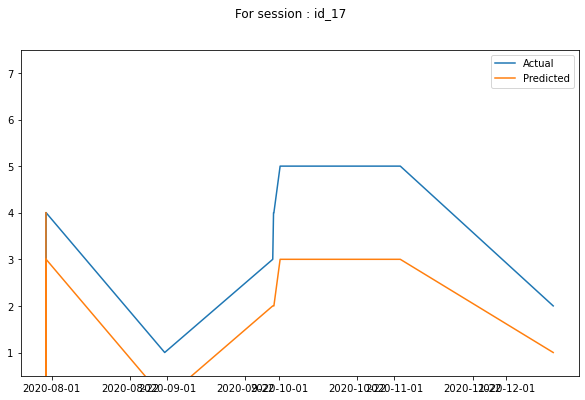

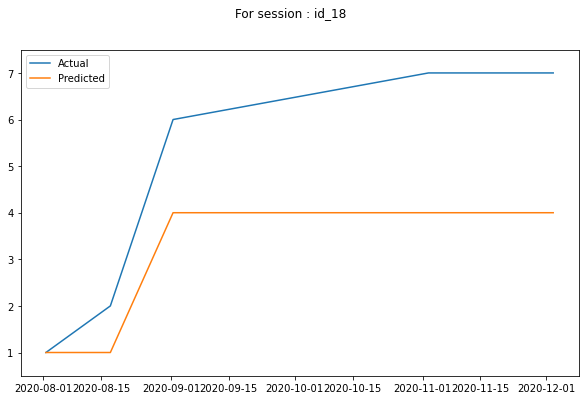

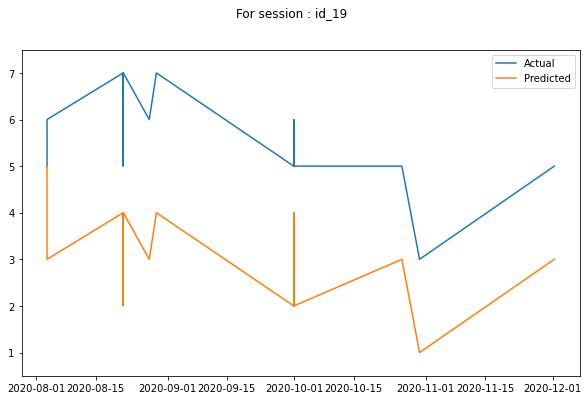

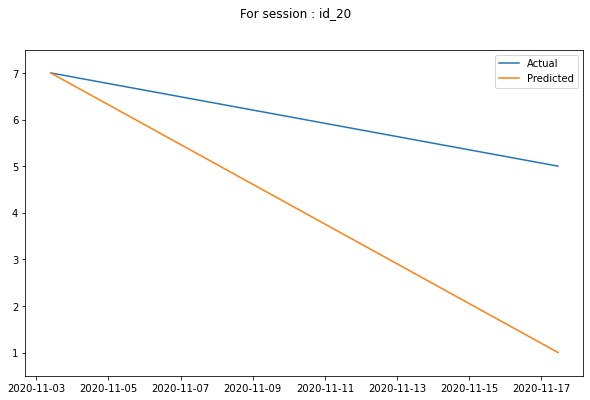

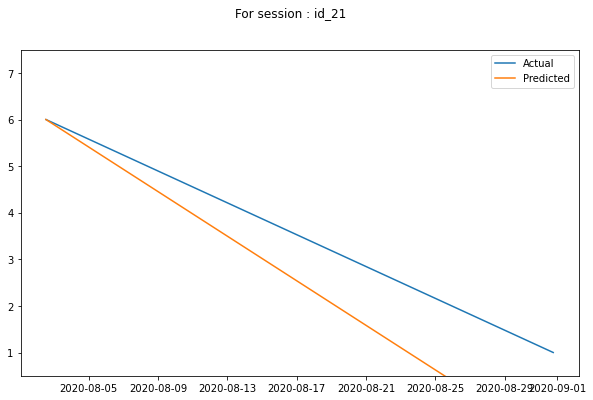

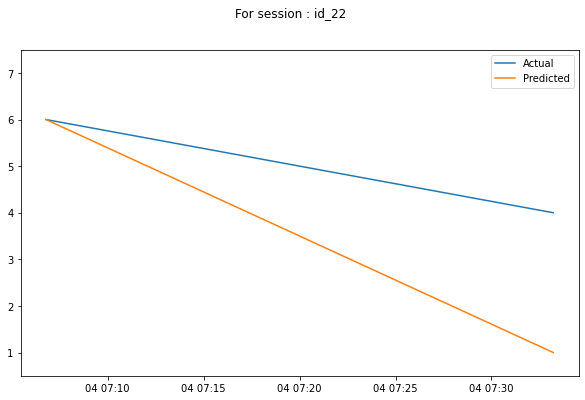

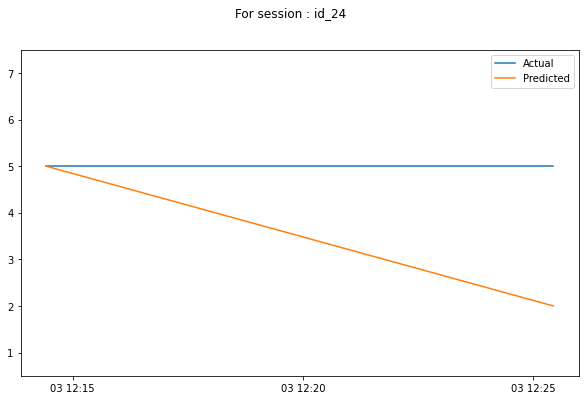

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

### 7. AR

In [ ]:
def calculate_autoregressive(log=True):
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]
        actual_series = list(input_data['battarie_energie'].astype(int))    
        try:
            ar_model = AutoReg(actual_series, lags=1).fit()
        except:
            continue
        
        pred = ar_model.predict()
        predicted_series = [ actual_series[0] ]
        predicted_series.extend( [int(np.round(x)) for x in pred ] )
        
        testScore = accuracy_score(actual_series, predicted_series)
        if log:
            print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data['ended'])
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_autoregressive()

For id:  id_1  accuracy is :  0.6190476190476191
For id:  id_2  accuracy is :  0.2962962962962963
For id:  id_3  accuracy is :  0.391304347826087
For id:  id_4  accuracy is :  0.7551020408163265
For id:  id_5  accuracy is :  0.3
For id:  id_6  accuracy is :  0.15789473684210525
For id:  id_7  accuracy is :  0.5384615384615384
For id:  id_8  accuracy is :  0.34782608695652173
For id:  id_9  accuracy is :  0.8333333333333334
For id:  id_10  accuracy is :  0.48717948717948717
For id:  id_11  accuracy is :  0.5
For id:  id_12  accuracy is :  0.3333333333333333
For id:  id_13  accuracy is :  0.34782608695652173
For id:  id_15  accuracy is :  0.3333333333333333
For id:  id_16  accuracy is :  0.5393258426966292
For id:  id_17  accuracy is :  0.25
For id:  id_18  accuracy is :  0.6
For id:  id_19  accuracy is :  0.35714285714285715


Average accuracy via autoregressive method is :  0.44374483001233256
              precision    recall  f1-score   support

           1       0.10      0.29      0.14         7
           2       0.50      0.71      0.59        52
           3       0.45      0.45      0.45        77
           4       0.32      0.32      0.32        95
           5       0.51      0.31      0.38       199
           6       0.51      0.51      0.51       136
           7       0.09      1.00      0.16         4

    accuracy                           0.42       570
   macro avg       0.35      0.51      0.37       570
weighted avg       0.46      0.42      0.43       570



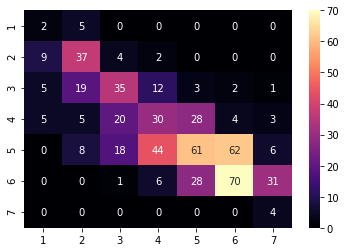

In [ ]:
print('Average accuracy via autoregressive method is : ', sum(accuracies)/len(accuracies))

true_all = np.hstack(list(actual_values.values()))
preds_all = np.hstack(list(predicted_values.values()))
classification_reports_all['AR'] = classification_report(preds_all , true_all, zero_division=True)

unique_pred = list( set( list(set(preds_all)) + list(set(true_all)) ) )
unique_pred.sort()
cmatrix = pandas.DataFrame(confusion_matrix(preds_all , true_all), columns=unique_pred)
cmatrix.index = unique_pred
_ = sns.heatmap(cmatrix, cmap="magma" , annot = True)
print(classification_reports_all['AR'])
accuracies_global['AR'] = accuracies

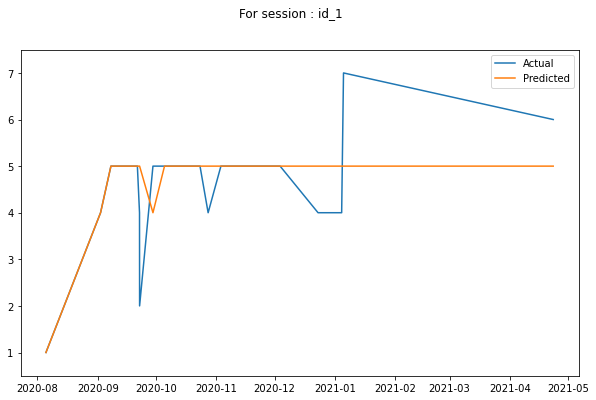

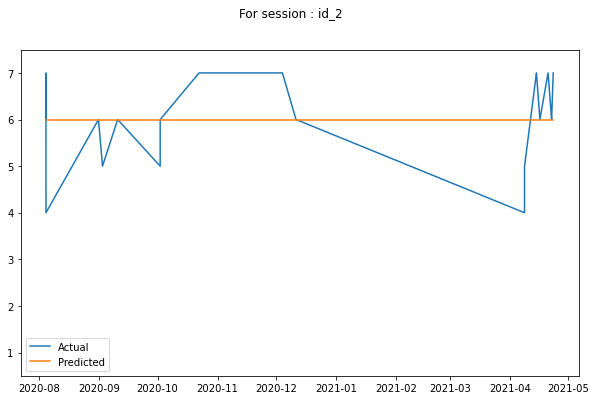

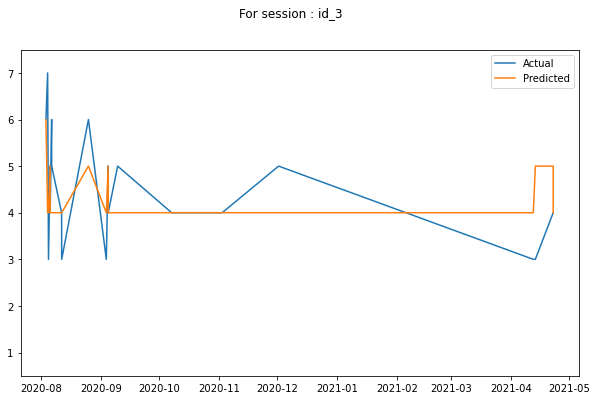

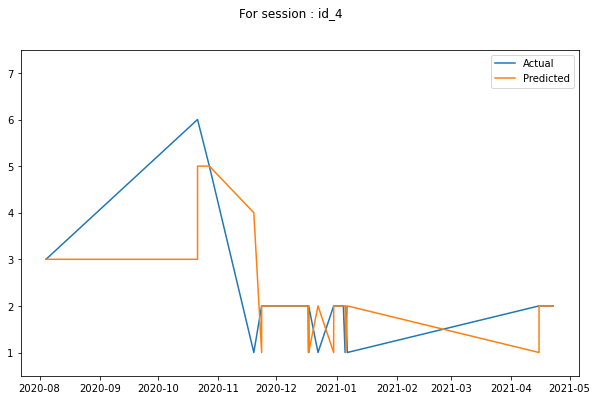

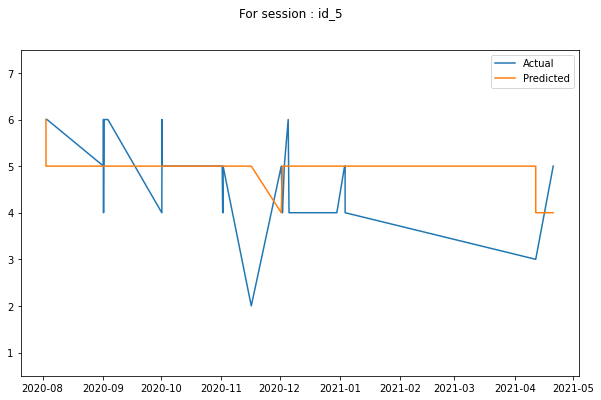

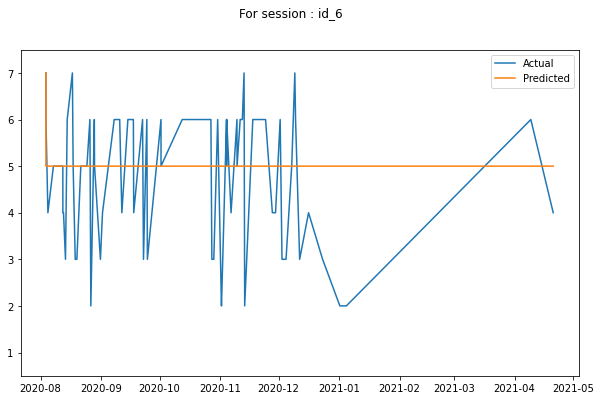

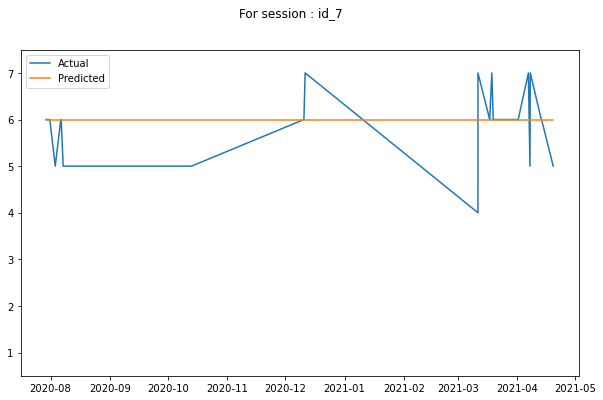

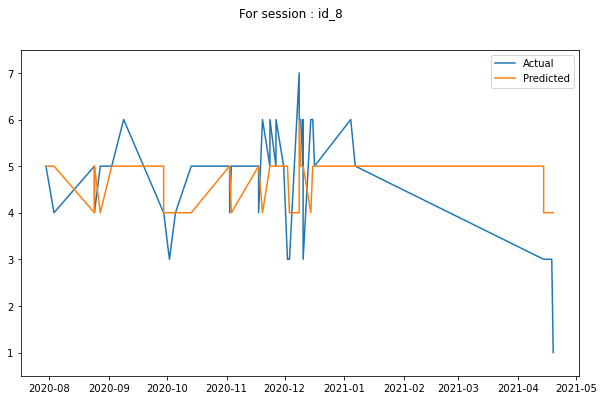

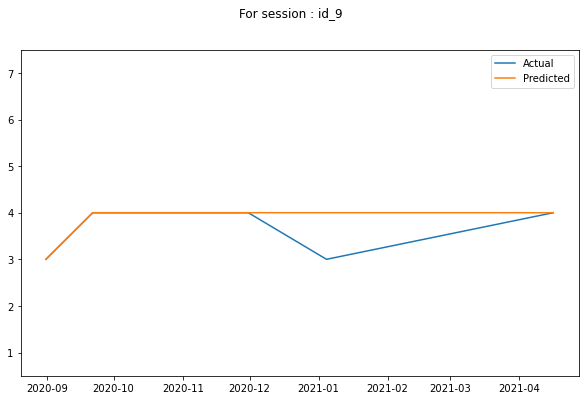

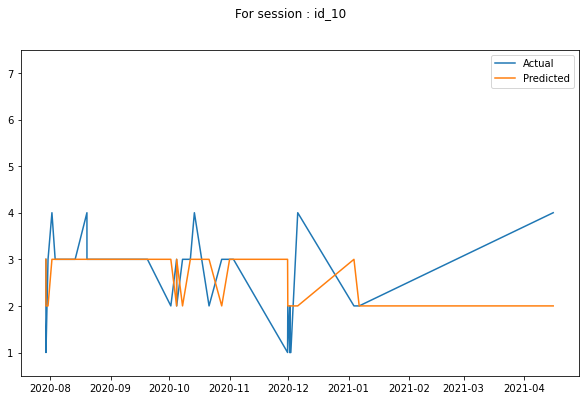

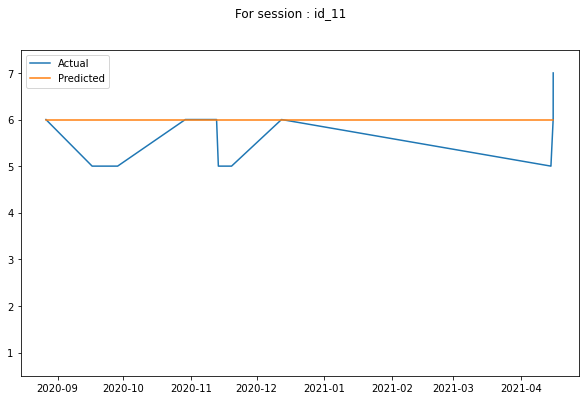

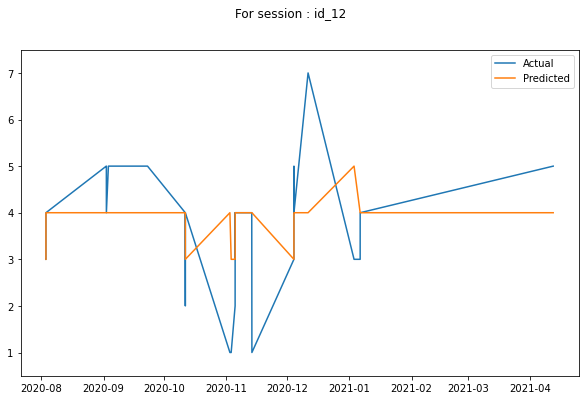

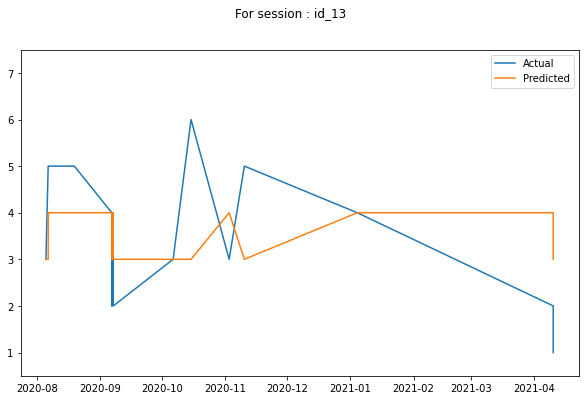

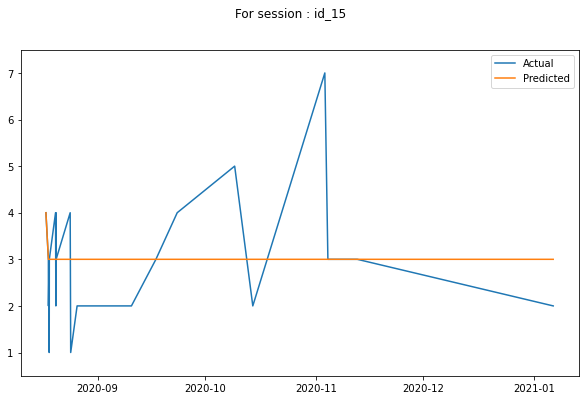

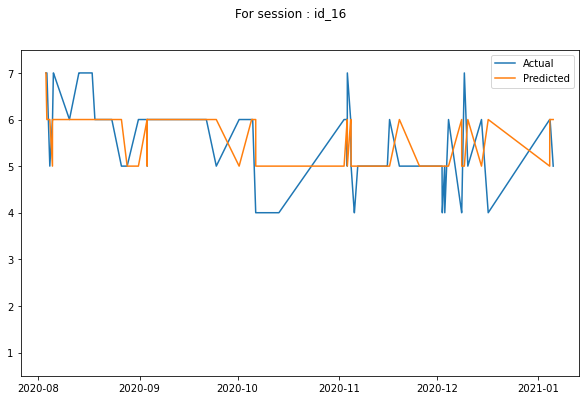

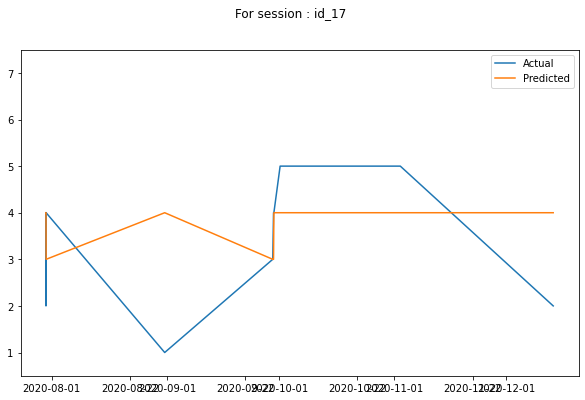

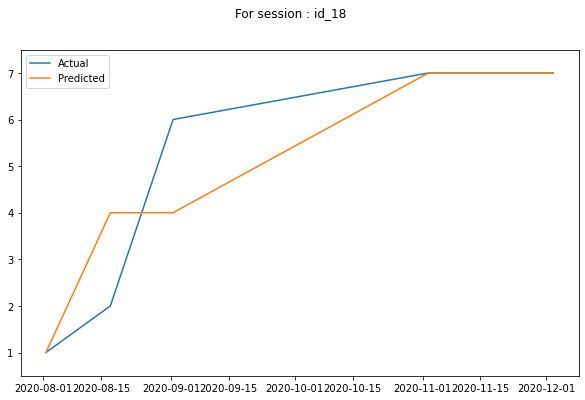

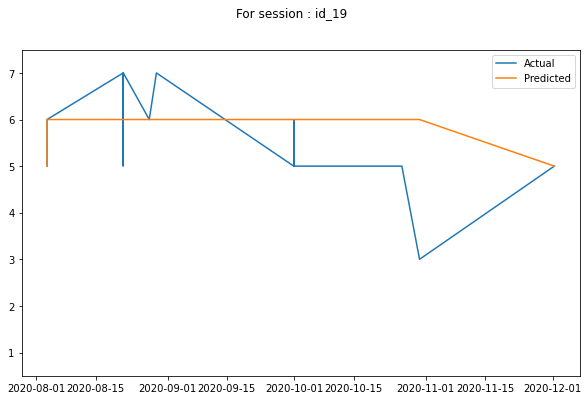

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

### 8. ARIMA

In [ ]:
def calculate_ARIMA(p,d,q,log=True):
    accuracies = []
    actual_values = {}
    predicted_values = {}
    timestamps = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]
        actual_series = list(input_data['battarie_energie'].astype(int))    
        try:
            model = ARIMA(actual_series, order=(p,d,q)).fit()
        except:
            continue
            
        predicted_series = [int(np.round(x)) for x in model.predict() ]
        
        testScore = accuracy_score(actual_series, predicted_series)
        if log:
            print('For id: ', session, ' accuracy is : ', testScore)
        
        accuracies.append(testScore)
        actual_values[session] = actual_series
        predicted_values[session] = predicted_series
        timestamps[session] = list(input_data['ended'])
        
    return accuracies, timestamps, actual_values, predicted_values

In [ ]:
for p in [1,2,3,4,5]:
    for d in [1,2,3,4,5]:
        for q in [1,2,3,4,5]:
            accuracies, timestamps, actual_values, predicted_values = calculate_ARIMA(p,d,q,log=False)
            print('Average accuracy for ARIMA method for p={} d={} q={} is {}'.format(p,d,q,sum(accuracies)/len(accuracies)))

Average accuracy for ARIMA method for p=1 d=1 q=1 is 0.35553116230655324
Average accuracy for ARIMA method for p=1 d=1 q=2 is 0.3605652268160599
Average accuracy for ARIMA method for p=1 d=1 q=3 is 0.39717735783715774
Average accuracy for ARIMA method for p=1 d=1 q=4 is 0.42566410253502207
Average accuracy for ARIMA method for p=1 d=1 q=5 is 0.43436614420820274
Average accuracy for ARIMA method for p=1 d=2 q=1 is 0.2503965338032741
Average accuracy for ARIMA method for p=1 d=2 q=2 is 0.23267253568849852
Average accuracy for ARIMA method for p=1 d=2 q=3 is 0.23964342456493695
Average accuracy for ARIMA method for p=1 d=2 q=4 is 0.23955330487395768
Average accuracy for ARIMA method for p=1 d=2 q=5 is 0.25694485626532787
Average accuracy for ARIMA method for p=1 d=3 q=1 is 0.19622637014333028
Average accuracy for ARIMA method for p=1 d=3 q=2 is 0.19861033407219522
Average accuracy for ARIMA method for p=1 d=3 q=3 is 0.19812467140528026
Average accuracy for ARIMA method for p=1 d=3 q=4 is 

Average accuracy for ARIMA method for p=5 d=3 q=4 is 0.2017734605570663
Average accuracy for ARIMA method for p=5 d=3 q=5 is 0.21803765676829046
Average accuracy for ARIMA method for p=5 d=4 q=1 is 0.14177694232723248
Average accuracy for ARIMA method for p=5 d=4 q=2 is 0.15038720471195596
Average accuracy for ARIMA method for p=5 d=4 q=3 is 0.1726419884681304
Average accuracy for ARIMA method for p=5 d=4 q=4 is 0.16057113520531302
Average accuracy for ARIMA method for p=5 d=4 q=5 is 0.18115611220847025
Average accuracy for ARIMA method for p=5 d=5 q=1 is 0.1468100323596241
Average accuracy for ARIMA method for p=5 d=5 q=2 is 0.1298430881465864
Average accuracy for ARIMA method for p=5 d=5 q=3 is 0.13913915758156833
Average accuracy for ARIMA method for p=5 d=5 q=4 is 0.13064575912135526
Average accuracy for ARIMA method for p=5 d=5 q=5 is 0.13100679459293382


In [ ]:
accuracies, timestamps, actual_values, predicted_values = calculate_ARIMA(4,1,4)

For id:  id_1  accuracy is :  0.47619047619047616
For id:  id_2  accuracy is :  0.5185185185185185
For id:  id_3  accuracy is :  0.2608695652173913
For id:  id_4  accuracy is :  0.7142857142857143
For id:  id_5  accuracy is :  0.55
For id:  id_6  accuracy is :  0.18421052631578946
For id:  id_7  accuracy is :  0.5384615384615384
For id:  id_8  accuracy is :  0.3695652173913043
For id:  id_9  accuracy is :  0.5
For id:  id_10  accuracy is :  0.38461538461538464
For id:  id_11  accuracy is :  0.7142857142857143
For id:  id_12  accuracy is :  0.30303030303030304
For id:  id_13  accuracy is :  0.43478260869565216
For id:  id_15  accuracy is :  0.3333333333333333
For id:  id_16  accuracy is :  0.5842696629213483
For id:  id_17  accuracy is :  0.4166666666666667
For id:  id_18  accuracy is :  0.4
For id:  id_19  accuracy is :  0.5


Average accuracy via ARIMA method is :  0.4546158461071742
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        19
           1       0.10      0.22      0.13         9
           2       0.59      0.69      0.64        64
           3       0.29      0.40      0.34        58
           4       0.33      0.30      0.31       104
           5       0.52      0.38      0.44       164
           6       0.56      0.60      0.58       128
           7       0.36      0.67      0.46        24

    accuracy                           0.45       570
   macro avg       0.47      0.41      0.36       570
weighted avg       0.48      0.45      0.44       570



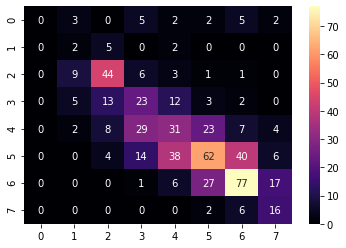

In [ ]:
print('Average accuracy via ARIMA method is : ', sum(accuracies)/len(accuracies))

true_all = np.hstack(list(actual_values.values()))
preds_all = np.hstack(list(predicted_values.values()))
classification_reports_all['ARIMA'] = classification_report(preds_all , true_all, zero_division=True)

unique_pred = list( set( list(set(preds_all)) + list(set(true_all)) ) )
unique_pred.sort()
cmatrix = pandas.DataFrame(confusion_matrix(preds_all , true_all), columns=unique_pred)
cmatrix.index = unique_pred
_ = sns.heatmap(cmatrix, cmap="magma" , annot = True)
print(classification_reports_all['ARIMA'])
accuracies_global['ARIMA'] = accuracies

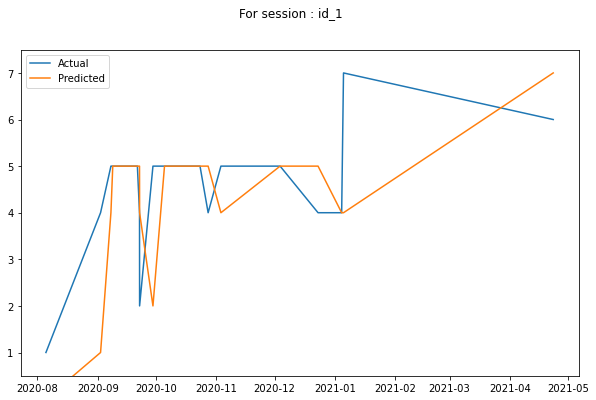

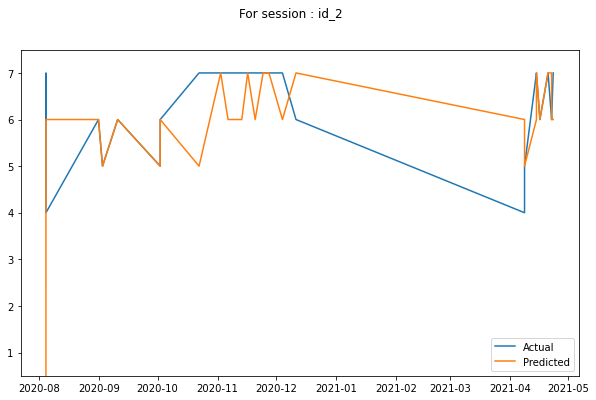

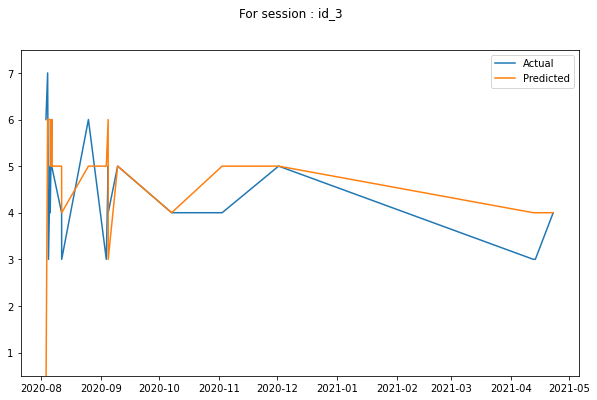

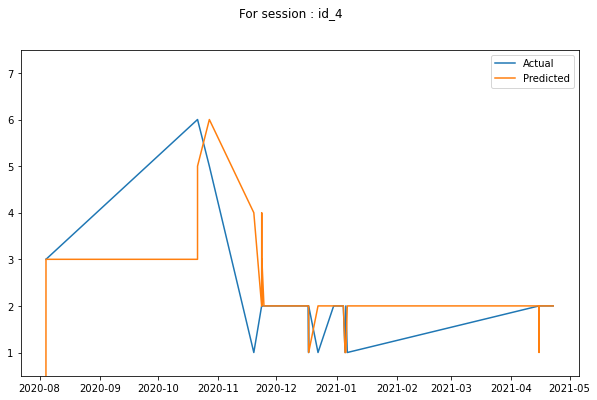

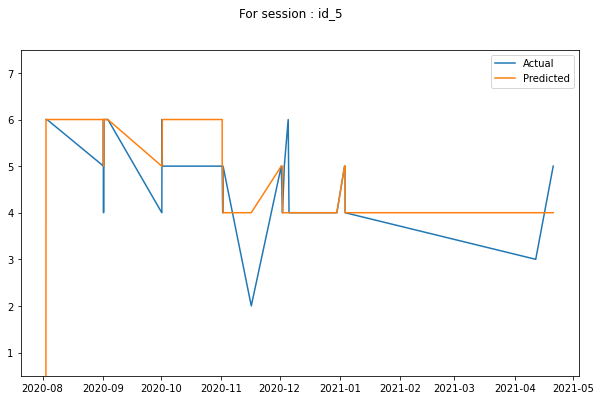

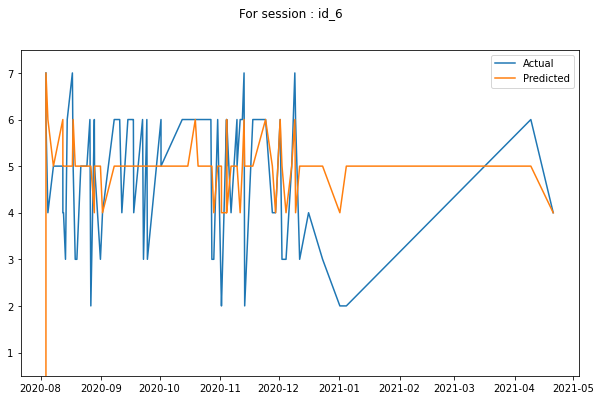

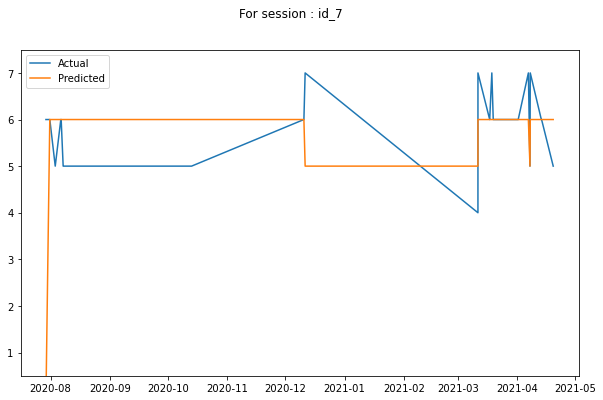

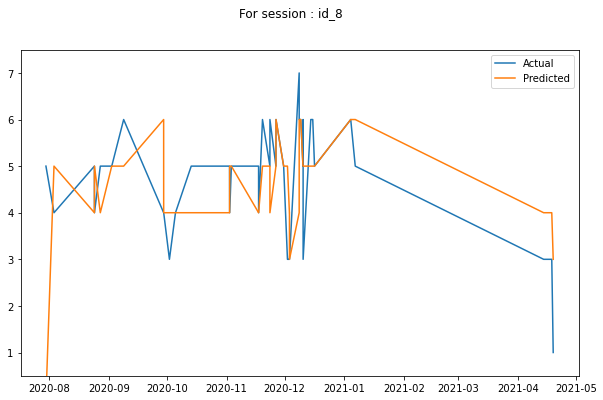

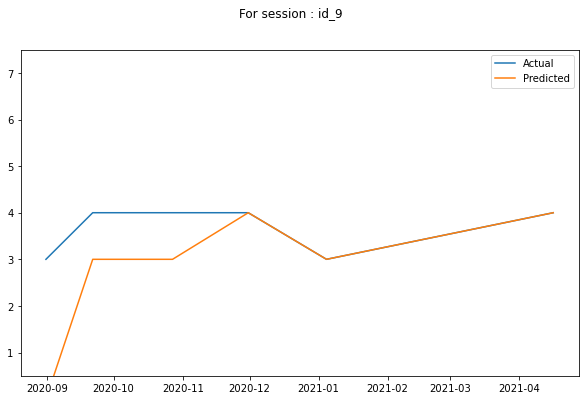

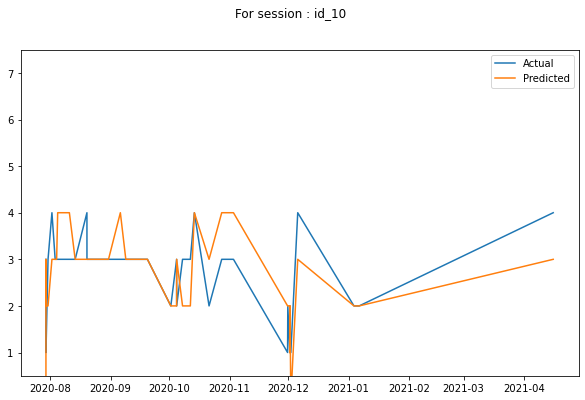

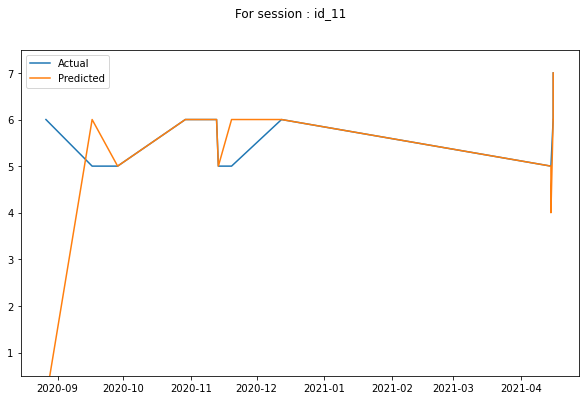

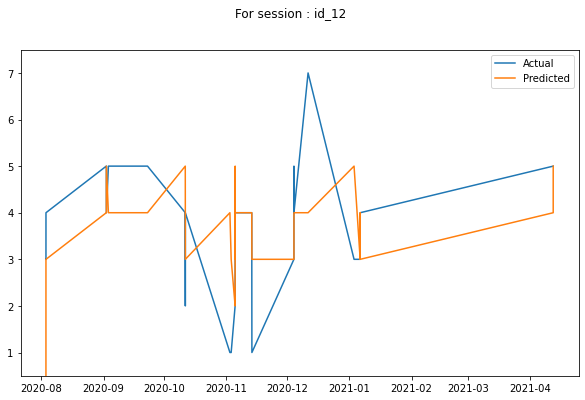

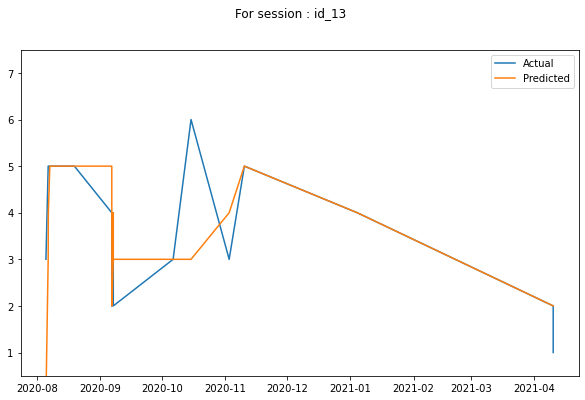

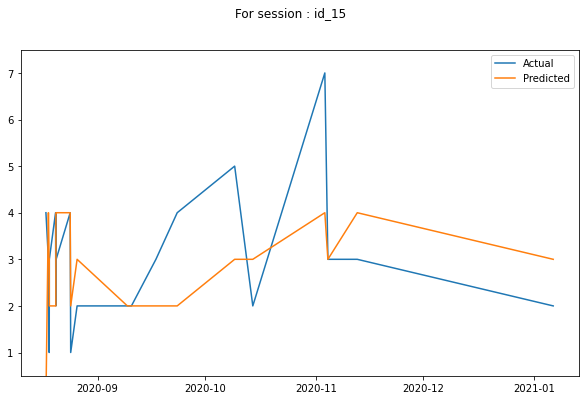

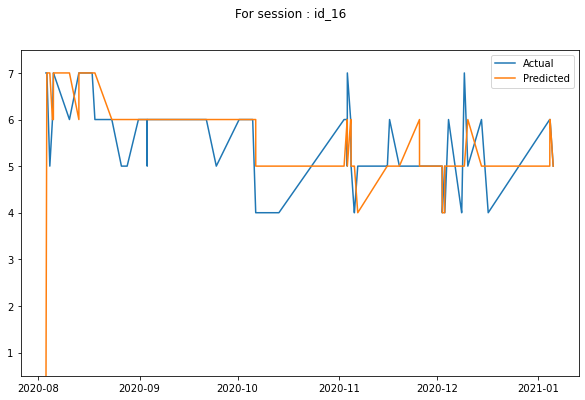

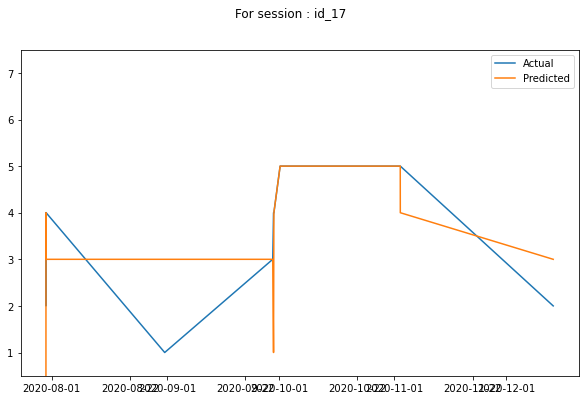

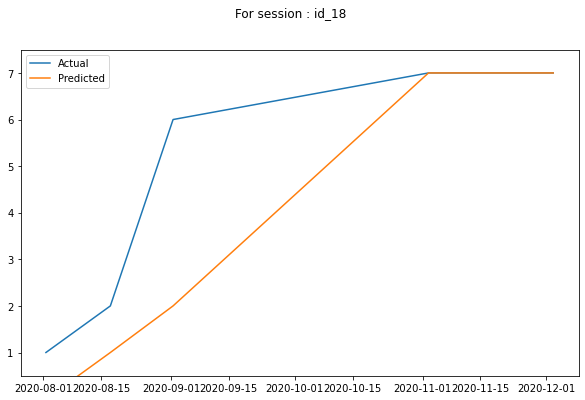

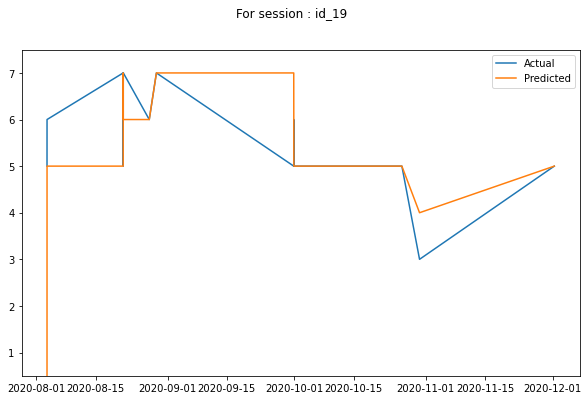

In [ ]:
plot_curves(timestamps, actual_values, predicted_values)

## Let's print all the classification reports here!

In [ ]:
classification_reports_all.keys()

dict_keys(['ARIMAX', 'SARIMAX(2)', 'FProphet', 'WinterHoltz', 'MA', 'EMA', 'AR', 'ARIMA'])

In [ ]:
for algo in classification_reports_all.keys():
    report = classification_reports_all[algo]
    print('For', algo, ' : ', report)

For ARIMAX  :                precision    recall  f1-score   support

           0       1.00      0.00      0.00        23
           1       0.18      0.20      0.19        20
           2       0.58      0.54      0.56        79
           3       0.41      0.43      0.42        75
           4       0.32      0.33      0.32        91
           5       0.44      0.37      0.40       148
           6       0.40      0.52      0.45       107
           7       0.35      0.44      0.39        36
           8       1.00      0.00      0.00         1

    accuracy                           0.41       580
   macro avg       0.52      0.32      0.30       580
weighted avg       0.44      0.41      0.40       580

For SARIMAX(2)  :                precision    recall  f1-score   support

          -1       1.00      0.00      0.00         2
           0       1.00      0.00      0.00        27
           1       0.23      0.23      0.23        22
           2       0.57      0.55      0.56 

### What is the highest accuracy we have seen so far?
#### We saw it for moving averages with windows size as 2!!
### Let's forecast the values for it

In [ ]:
def forecast_simple_moving_average(total_forecasts=5):

    def moving_average(x, w):
        complete = np.convolve(x, np.ones(w), 'valid') // w
        full = [x[0]]
        for i in range(w-2):
            full.append( np.mean(np.array(full)) )
        full.extend(complete)
        return full
    
    actual = {}
    fitted = {}
    forecasts = {}
    
    for session in data['session'].unique():
        input_data = data[ data['session'] == session ]
        actual_series = list(input_data['battarie_energie'].astype(int))
        ma_series = moving_average(actual_series, 2)
        
        actual[session] = actual_series
        fitted[session] = [ int(np.round(x)) for x in ma_series ]
        
        forecast_series = [ma_series[-2], ma_series[-1]]
        for r in range(total_forecasts):
            forecast_series.append( (forecast_series[-2] + forecast_series[-1])//2 )
        forecast_series = forecast_series[2:]
        forecasts[session] = [ int(np.round(x)) for x in forecast_series ]
        
    return actual, fitted, forecasts

In [ ]:
actual, fitted, forecasts = forecast_simple_moving_average()

Forecast for session :  id_1


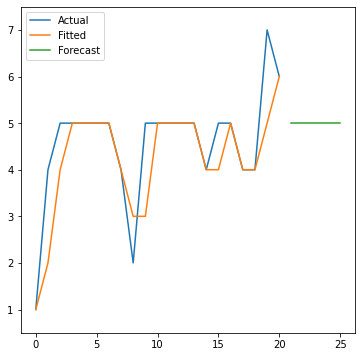

Forecast for session :  id_2


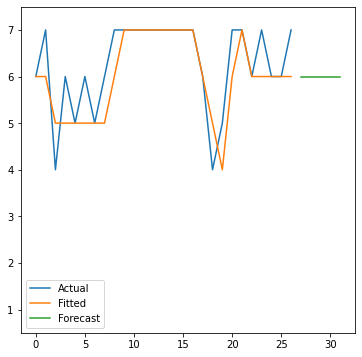

Forecast for session :  id_3


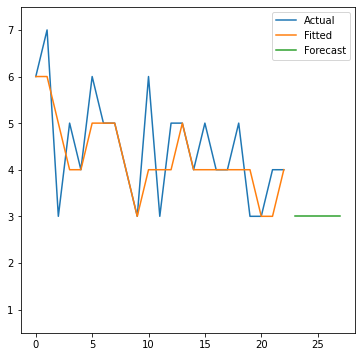

Forecast for session :  id_4


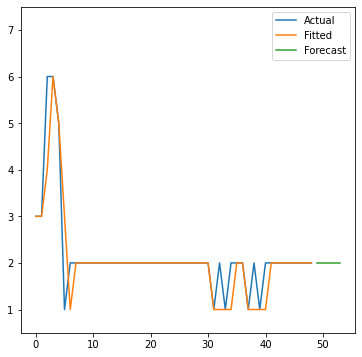

Forecast for session :  id_5


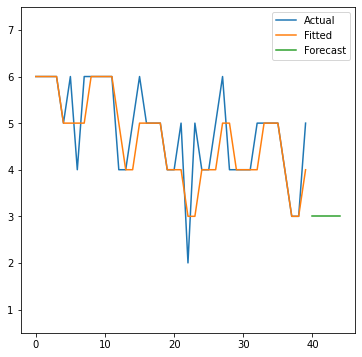

Forecast for session :  id_6


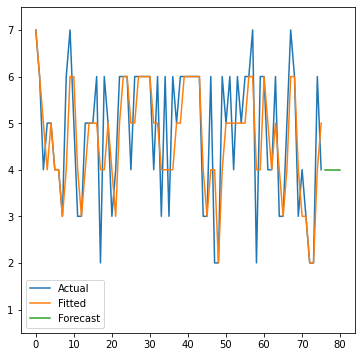

Forecast for session :  id_7


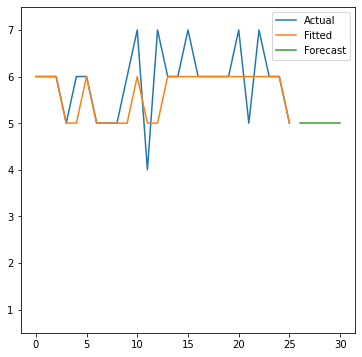

Forecast for session :  id_8


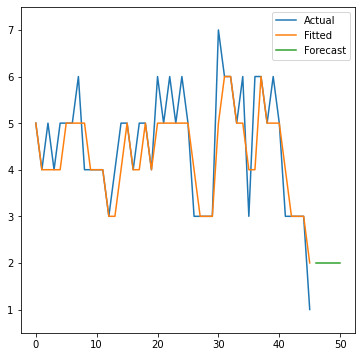

Forecast for session :  id_9


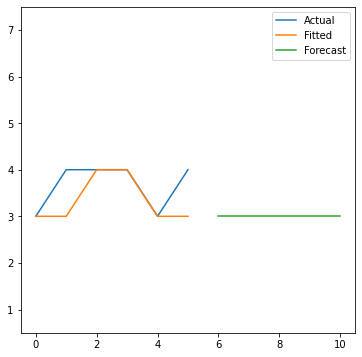

Forecast for session :  id_10


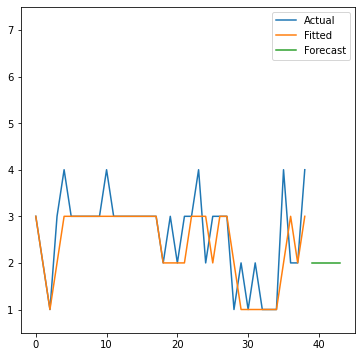

Forecast for session :  id_11


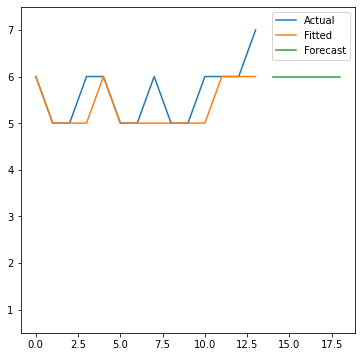

Forecast for session :  id_12


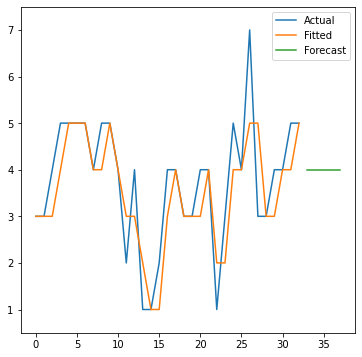

Forecast for session :  id_13


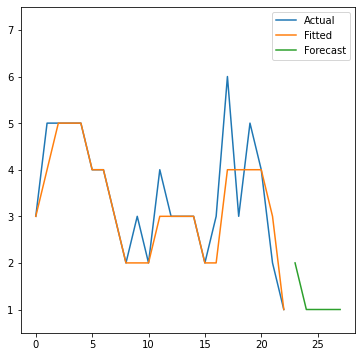

Forecast for session :  id_14


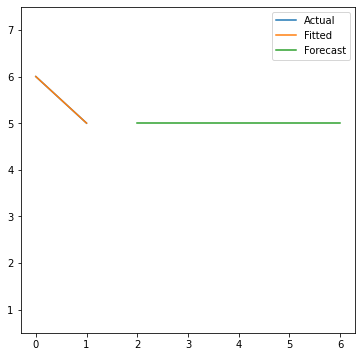

Forecast for session :  id_15


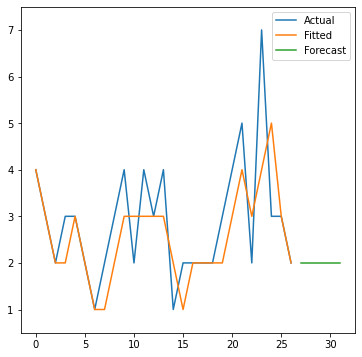

Forecast for session :  id_16


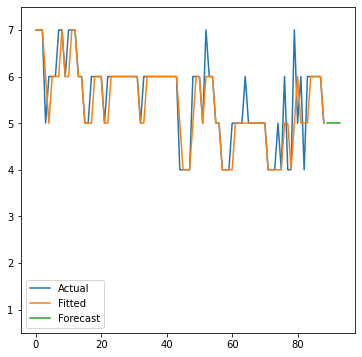

Forecast for session :  id_17


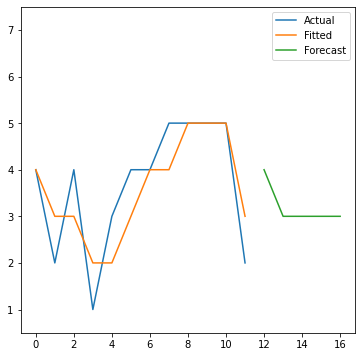

Forecast for session :  id_18


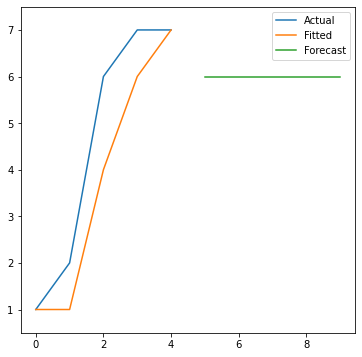

Forecast for session :  id_19


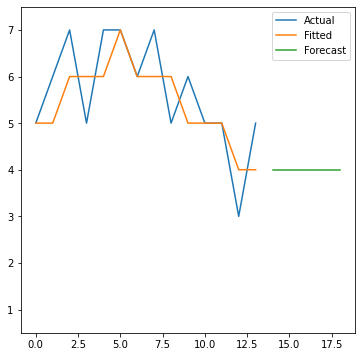

Forecast for session :  id_20


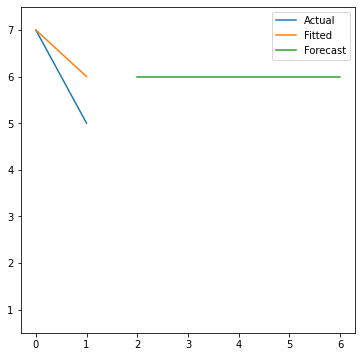

Forecast for session :  id_21


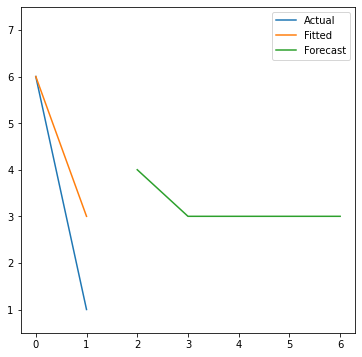

Forecast for session :  id_22


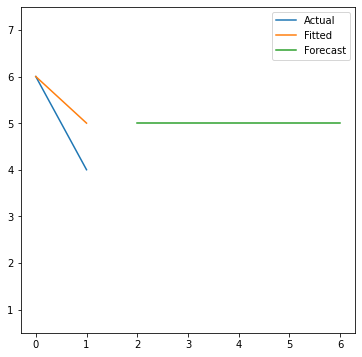

Forecast for session :  id_24


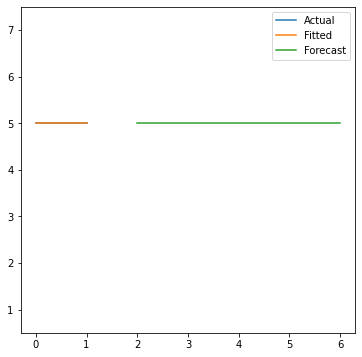

In [ ]:
for key in forecasts.keys():
    print('Forecast for session : ', key)
    plt.figure(figsize=(6,6))
    plt.ylim([0.5,7.5])
    actual_index = [ i for i in range(len(actual[key])) ]
    plt.plot(actual_index, actual[key], label='Actual')
    plt.plot(actual_index, fitted[key], label='Fitted')
    plt.plot([len(actual_index) + i for i in range(len(forecasts[key]))], forecasts[key], label='Forecast')
    plt.legend()
    plt.show()